### Further clean SPEND & PAYMENT variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
# train, test = drop_temp_columns(train, test)

In [7]:
START = time.time()

### Read Data

In [8]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/raw_spend_payment.parquet")
test = read_file(f"{RAW_TEST_PARQUET_PATH}/raw_spend_payment.parquet")

Shape of data: (5531451, 26)
Shape of data: (11363762, 26)
CPU times: user 3.33 s, sys: 2.6 s, total: 5.93 s
Wall time: 3.59 s


In [9]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 770 ms, sys: 231 ms, total: 1 s
Wall time: 1 s


In [10]:
train.shape, test.shape

((5531451, 27), (11363762, 26))

In [11]:
train_cid_list = train["customer_ID"].unique().tolist()

In [12]:
print(sorted(get_cols(train, ["P_", "S_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


In [13]:
train["target"].mean()

0.24909720794778803

### P_2

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


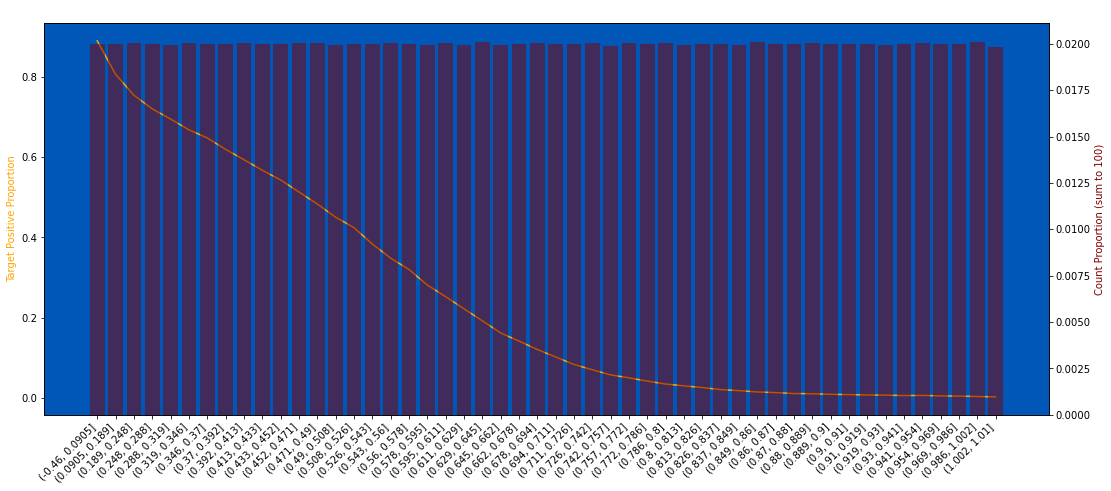

In [14]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [15]:
%%time
train, test = round_dfs(train, test, col="P_2", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 242 ms, sys: 632 ms, total: 874 ms
Wall time: 1.79 s


45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


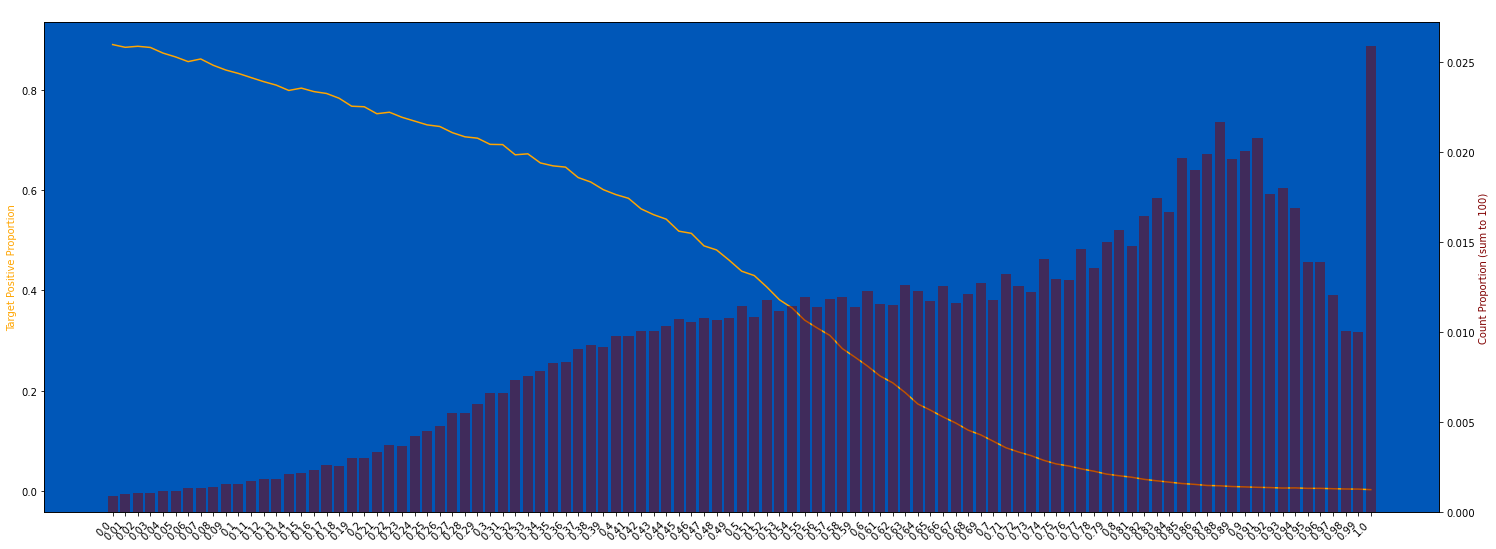

In [16]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10))

Bottom 1% and Top 1% are dropped from this chart


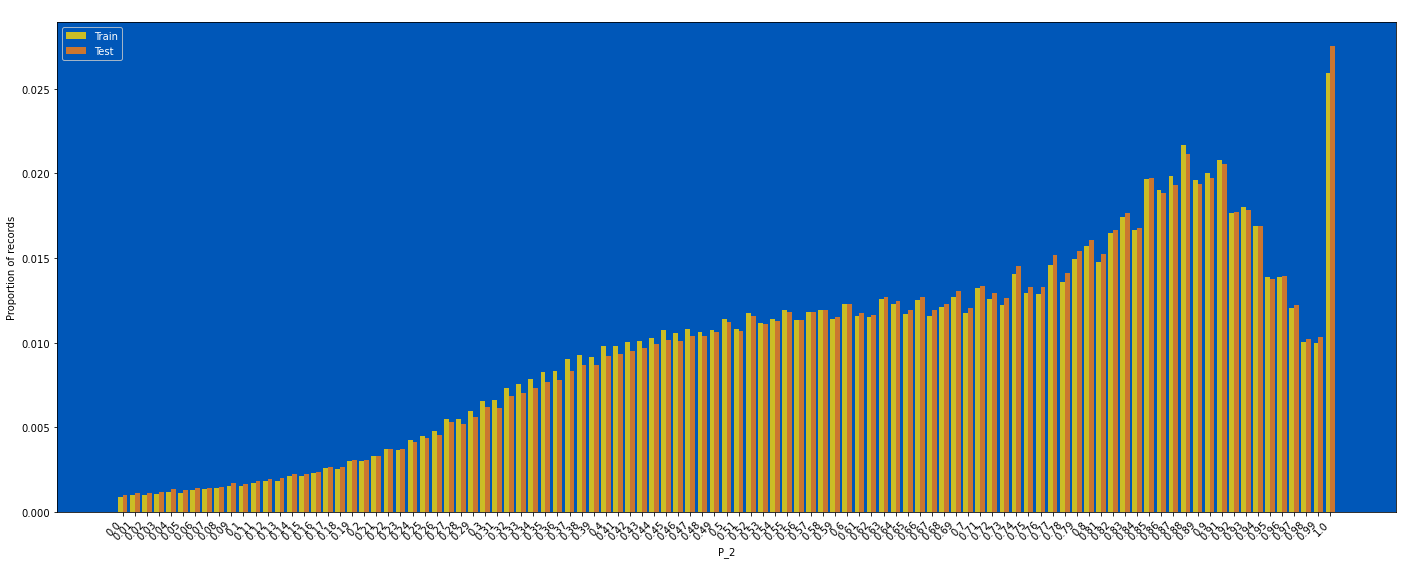

In [17]:
train_test = plot_train_test_distribution(train, test, "P_2", nunique_thr=150, figsize=(24, 10), return_df=True)

In [18]:
# from scipy.stats import ks_2samp
# import numpy as np
# ks_2samp(train["P_2"].dropna(), test["P_2"].dropna())

In [19]:
# plot_sampled_time_series(train, labels, "P_2", 50)

### P_3

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


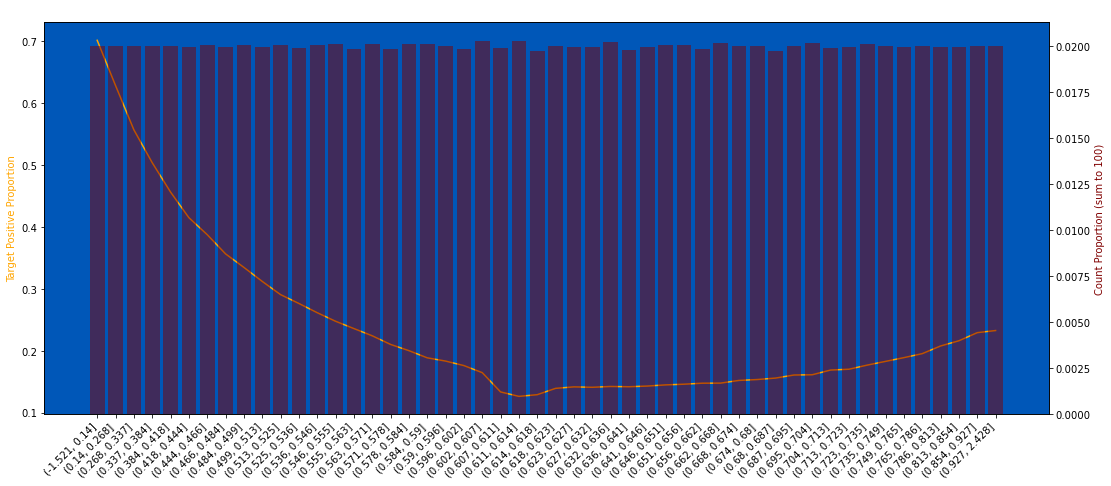

In [20]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [21]:
%%time
train, test = round_dfs(train, test, col="P_3", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 233 ms, sys: 613 ms, total: 846 ms
Wall time: 1.76 s


301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


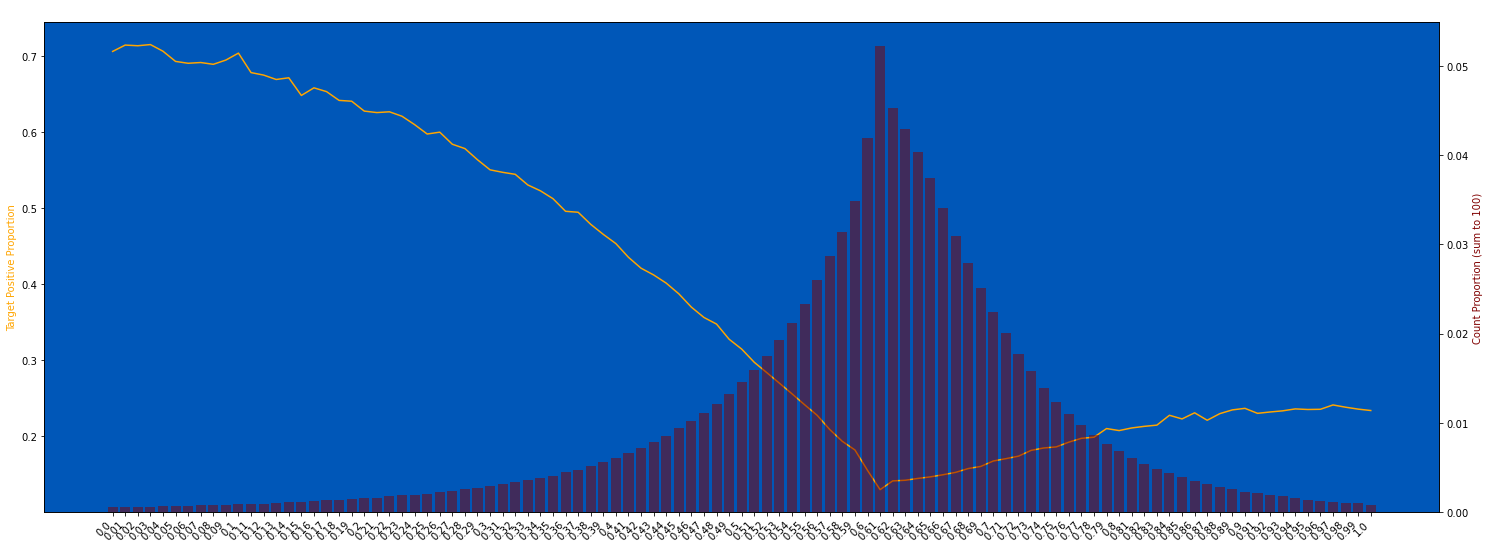

In [22]:
p3_summary = plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, figsize=(25, 10), 
                               drop_outlier=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


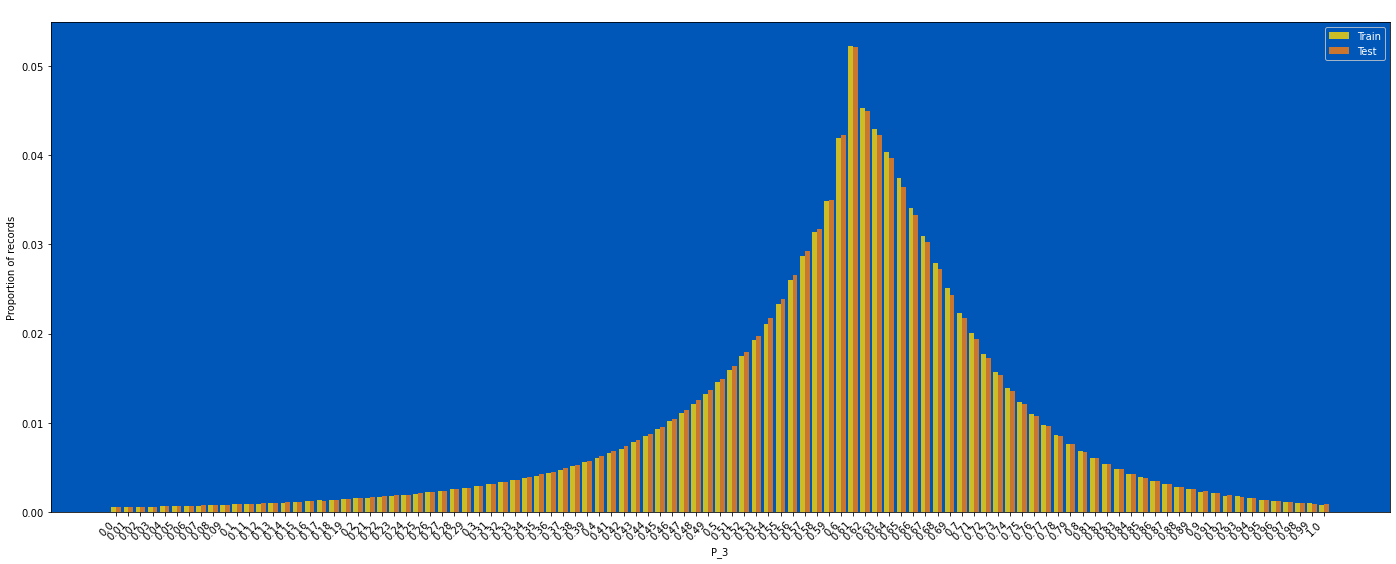

In [23]:
plot_train_test_distribution(train, test, "P_3", nunique_thr=340, figsize=(24, 10))

### P_4

0 null count, 0.000 null proportion
nan of the targets have label = 1


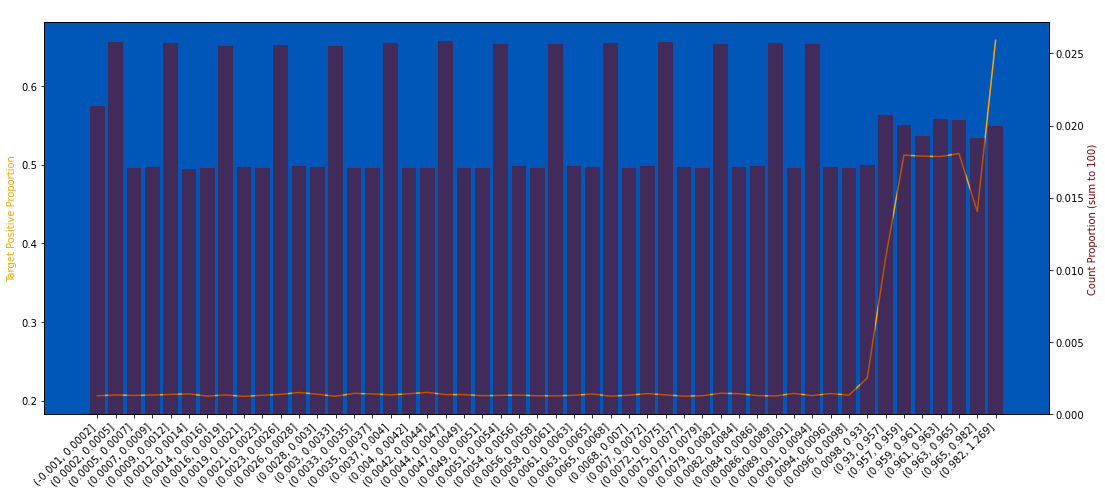

In [24]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [25]:
%%time
train, test = round_dfs(train, test, col="P_4", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 231 ms, sys: 655 ms, total: 886 ms
Wall time: 1.78 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


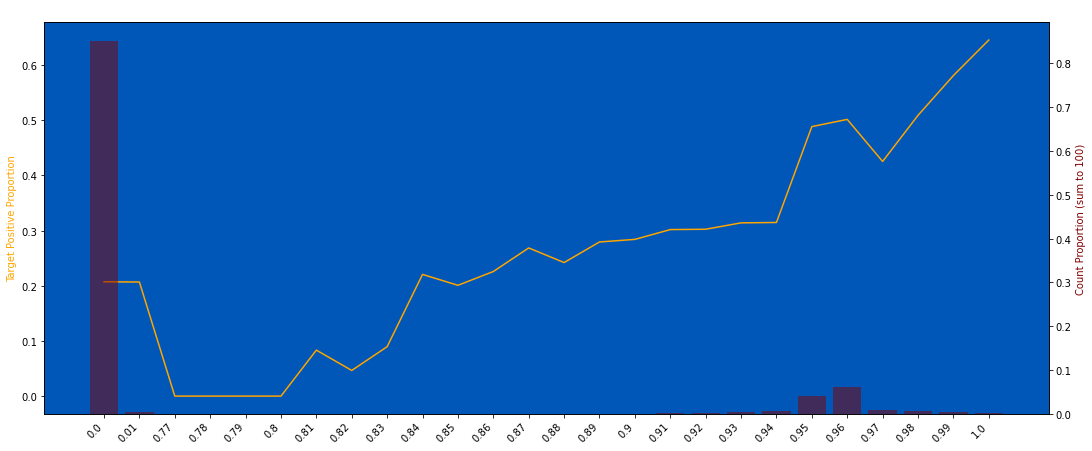

In [26]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

**Comments:**
- P_4 in (0, 0.01) should be NaN, because it has different default trend + extremely low values (outlier)
- Also, original P_4 has no missing values

In [27]:
%%time
train, test = fill_nans(train, test, col="P_4", tuple_of_values=(0, 0.01), add_new_col=False)

CPU times: user 324 ms, sys: 1.4 s, total: 1.72 s
Wall time: 332 ms


4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


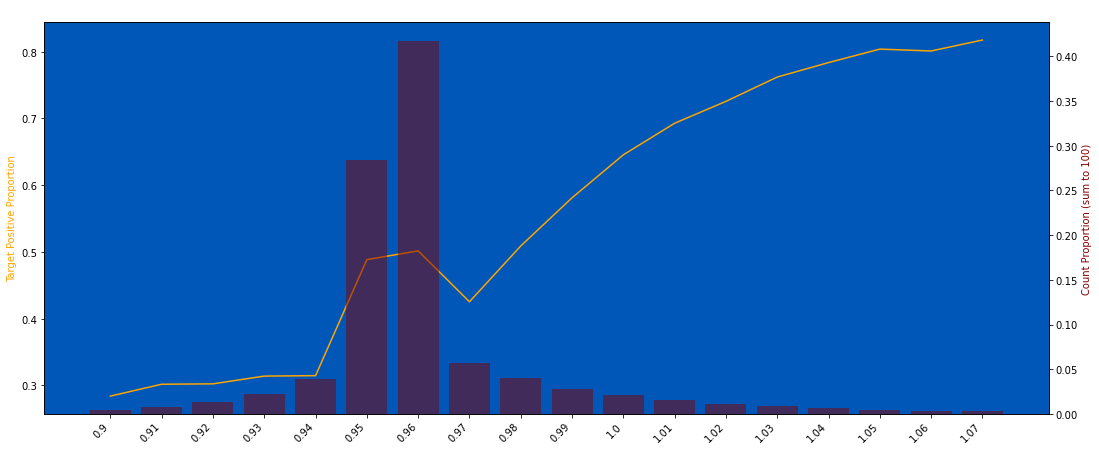

In [28]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

In [29]:
train["P_4_"] = train["P_4"].copy()
test["P_4_"] = test["P_4"].copy()

In [30]:
train.loc[train["P_4"].between(0.95, 0.96), "P_4_"] = np.nan
test.loc[test["P_4"].between(0.95, 0.96), "P_4_"] = np.nan

In [31]:
for col in train.columns[2:]:
    if col == "temp":
        continue
    corrcoef = train[["P_4_", col]].dropna().corr().iloc[0, 1]
    if abs(corrcoef) >= 0.3:
        print(col, corrcoef)

P_2 -0.6000156267280615
P_3 -0.8576832632093405
P_4 1.0
target 0.3284886163043049
P_4_ 1.0


In [32]:
train["P_2"].describe()

count   5,485,466.0000
mean            0.6514
std             0.2447
min            -0.4600
25%             0.4800
50%             0.6900
75%             0.8600
max             1.0100
Name: P_2, dtype: float64

In [33]:
train.loc[train["P_2"].isnull(), "P_4"].describe()

count   19,954.0000
mean         0.9560
std          0.0049
min          0.9500
25%          0.9500
50%          0.9600
75%          0.9600
max          0.9600
Name: P_4, dtype: float64

In [34]:
np.percentile(train.loc[train["P_2"].isnull(), "P_4"].dropna(), 0)

0.95

In [35]:
np.percentile(train.loc[train["P_2"].isnull(), "P_4"].dropna(), 99)

0.96

**Comments:**
- When P_2 is null, P_4 is always 0.95 - 0.96
- Replace those P_4 (0.95 - 0.96) with NaN

In [36]:
train.loc[(train["P_4"].between(0.95, 0.96)) & (train["P_2"].isnull()), "P_4"] = np.nan
test.loc[(test["P_4"].between(0.95, 0.96)) & (test["P_2"].isnull()), "P_4"] = np.nan

4752460 null count, 0.859 null proportion
0.2083 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


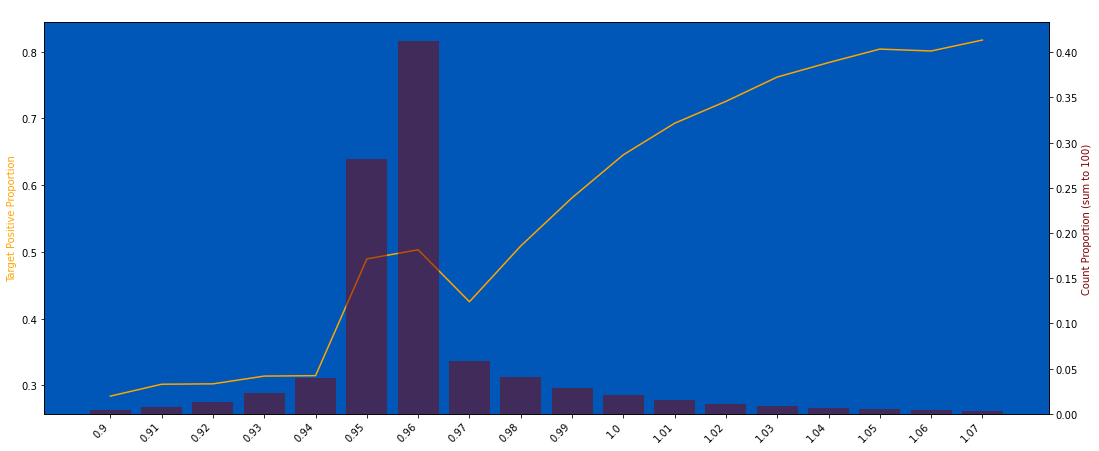

In [37]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

**Comments:**
- Disappointedly, not much changes

Bottom 1% and Top 1% are dropped from this chart


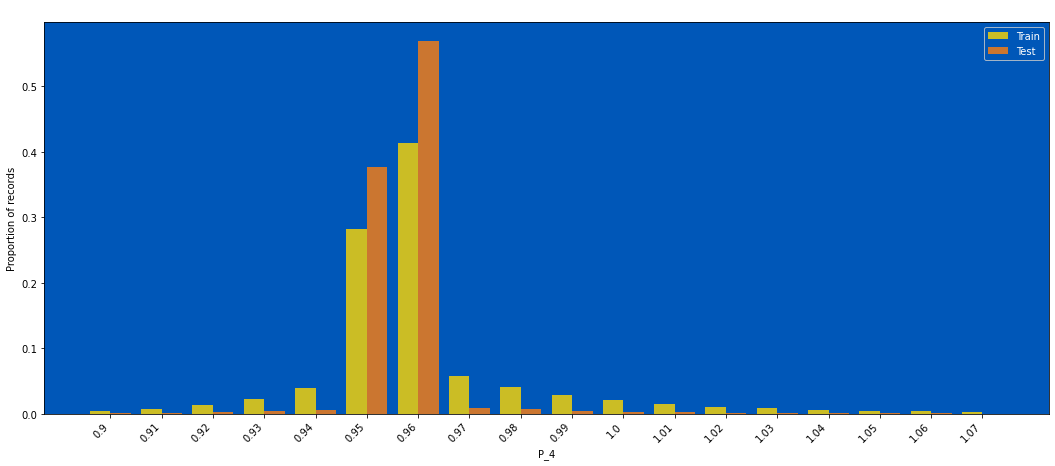

In [38]:
plot_train_test_distribution(train, test, "P_4")

**Train Test Skew: Slight**

### S_3

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


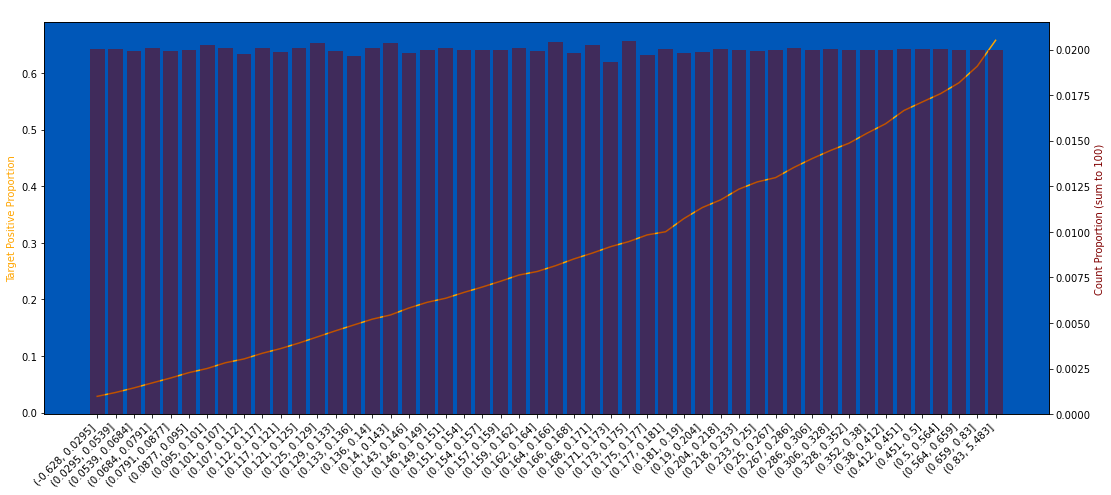

In [39]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [40]:
%%time
train, test = round_dfs(train, test, col="S_3", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 245 ms, sys: 662 ms, total: 907 ms
Wall time: 1.85 s


1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


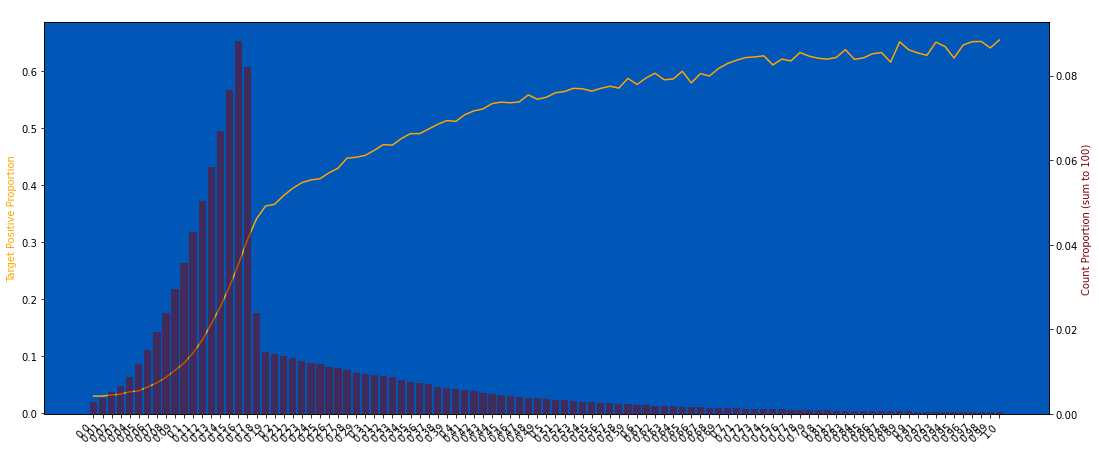

In [41]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


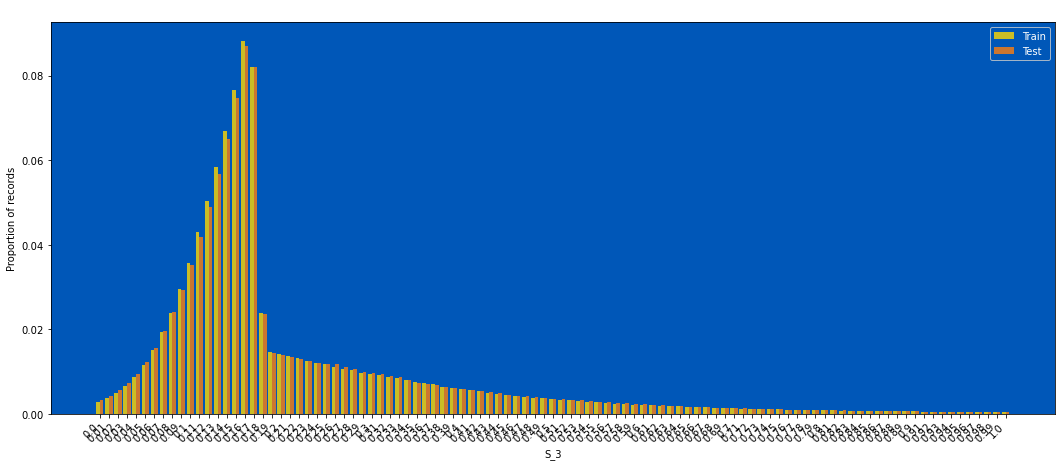

In [42]:
plot_train_test_distribution(train, test, "S_3", nunique_thr=500)

### S_5

0 null count, 0.000 null proportion
nan of the targets have label = 1


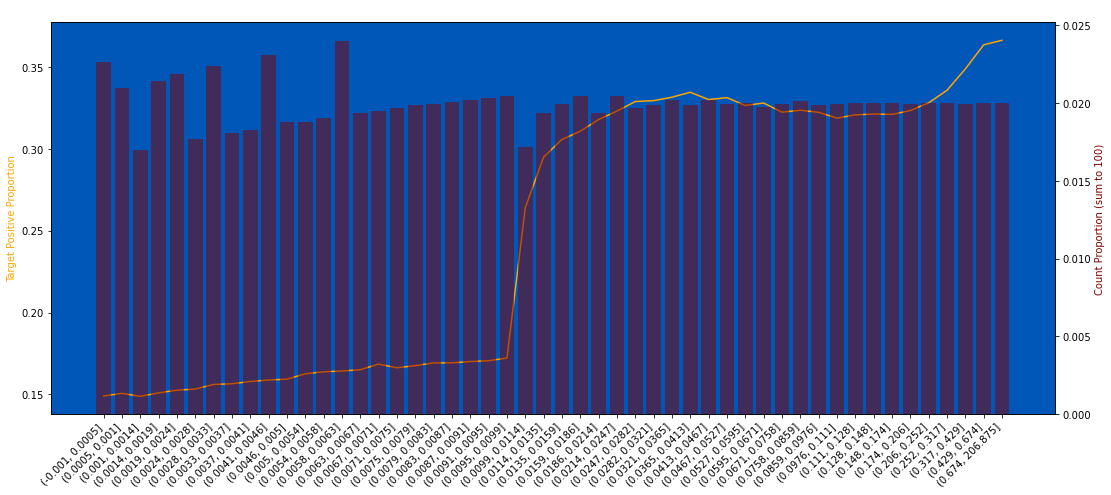

In [43]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [44]:
%%time
train, test = round_dfs(train, test, col="S_5", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 220 ms, sys: 667 ms, total: 887 ms
Wall time: 1.79 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


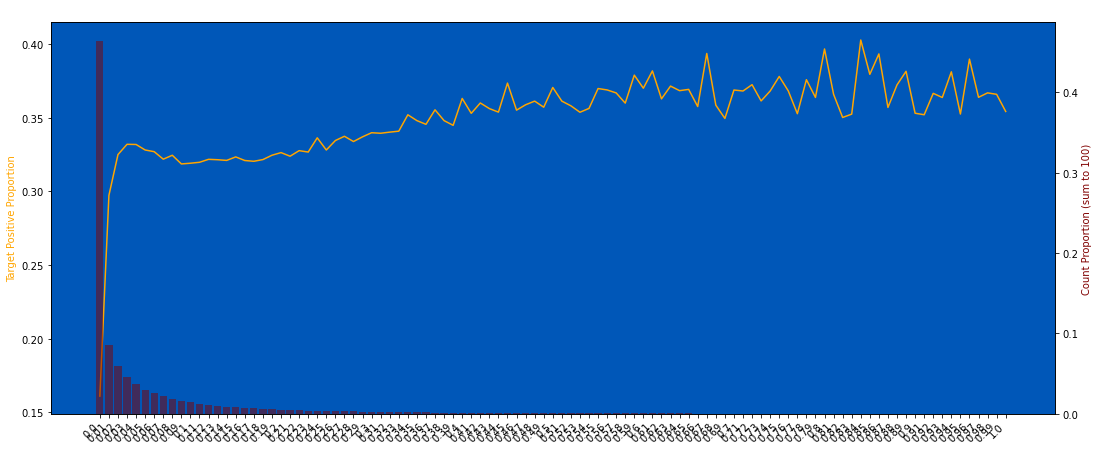

In [45]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


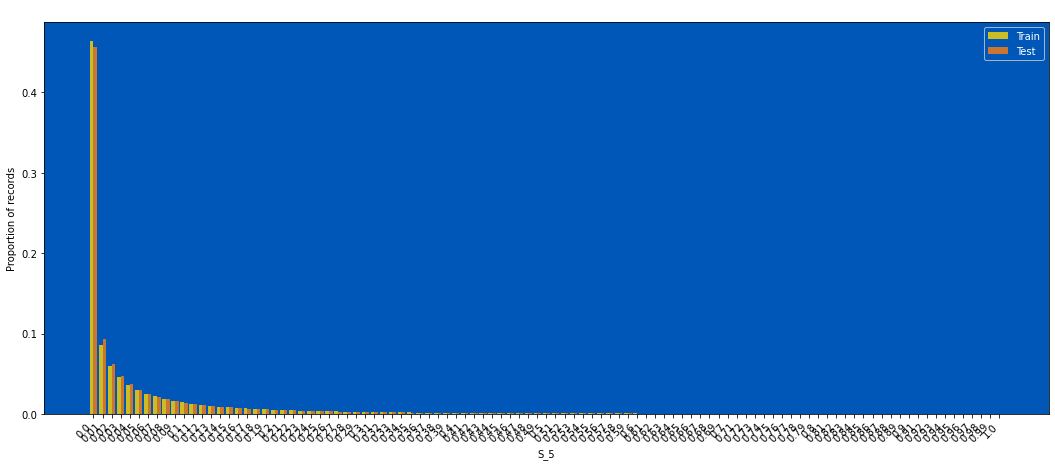

In [46]:
plot_train_test_distribution(train, test, "S_5", nunique_thr=5000)

### S_6

0 null count, 0.000 null proportion
nan of the targets have label = 1


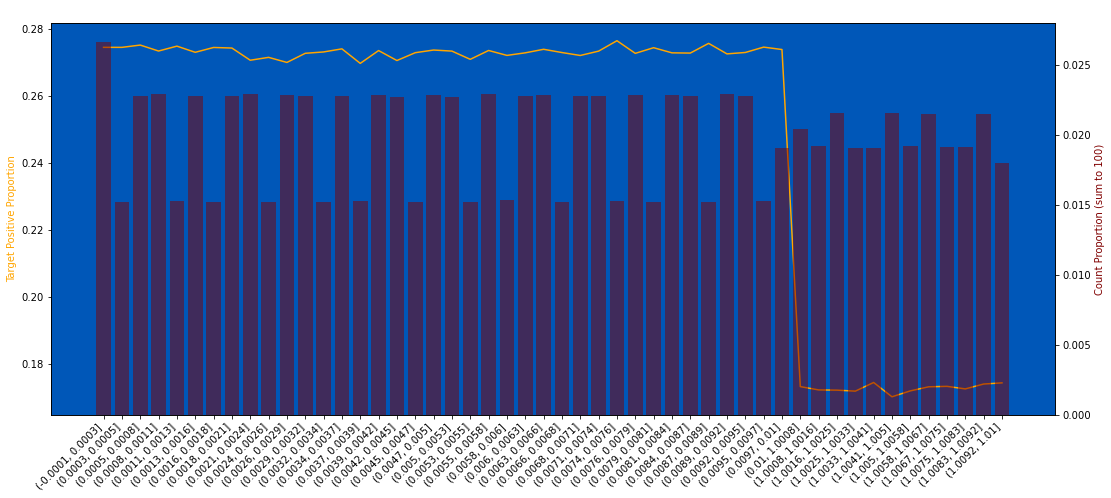

In [47]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

In [48]:
%%time
train, test = round_dfs(train, test, col="S_6", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 241 ms, sys: 711 ms, total: 952 ms
Wall time: 1.83 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


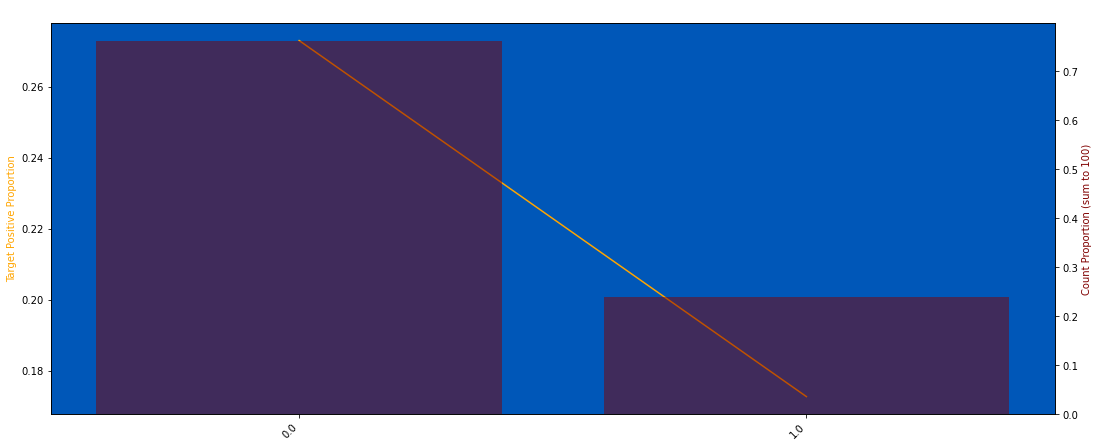

In [49]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [50]:
train["S_6"] = integerize(train["S_6"])
test["S_6"] = integerize(test["S_6"])

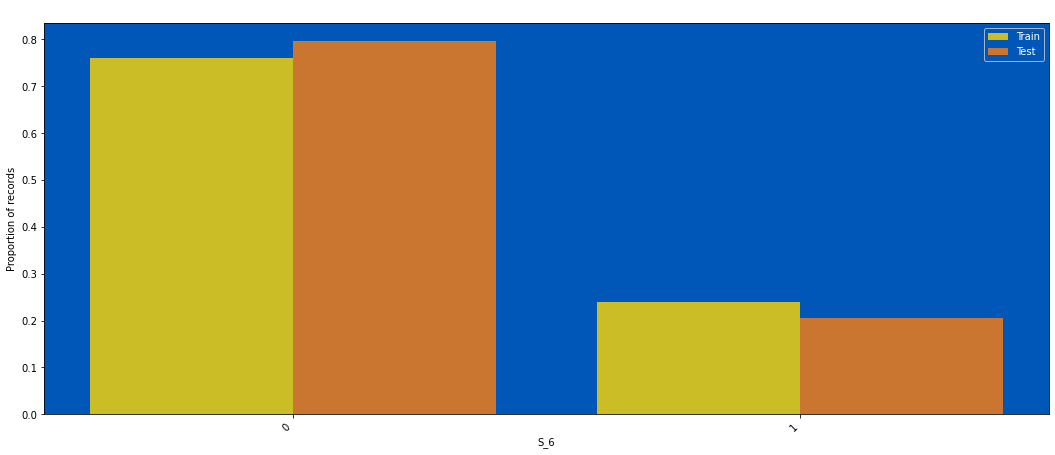

In [51]:
plot_train_test_distribution(train, test, "S_6", nunique_thr=50)

### S_7

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


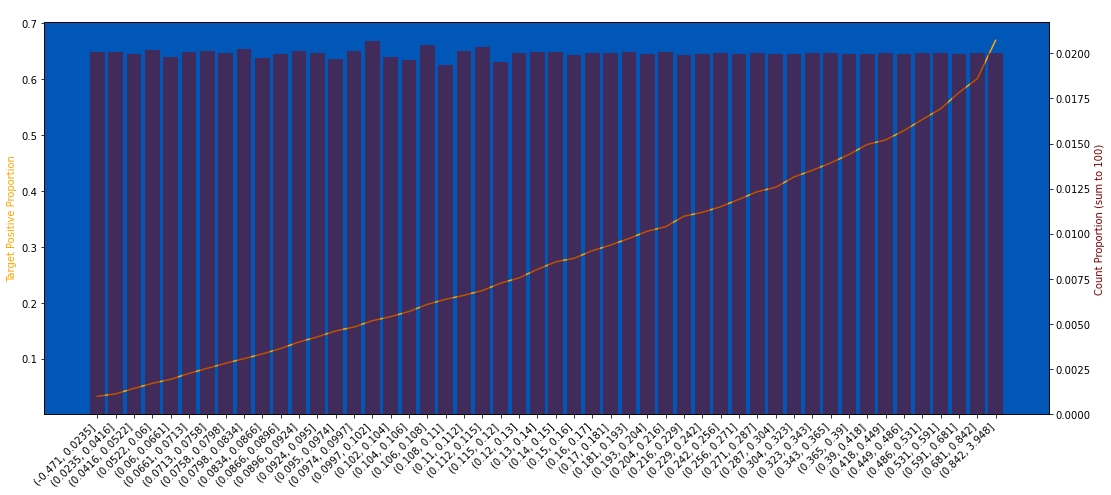

In [52]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [53]:
%%time
train, test = round_dfs(train, test, col="S_7", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 217 ms, sys: 661 ms, total: 878 ms
Wall time: 1.84 s


1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


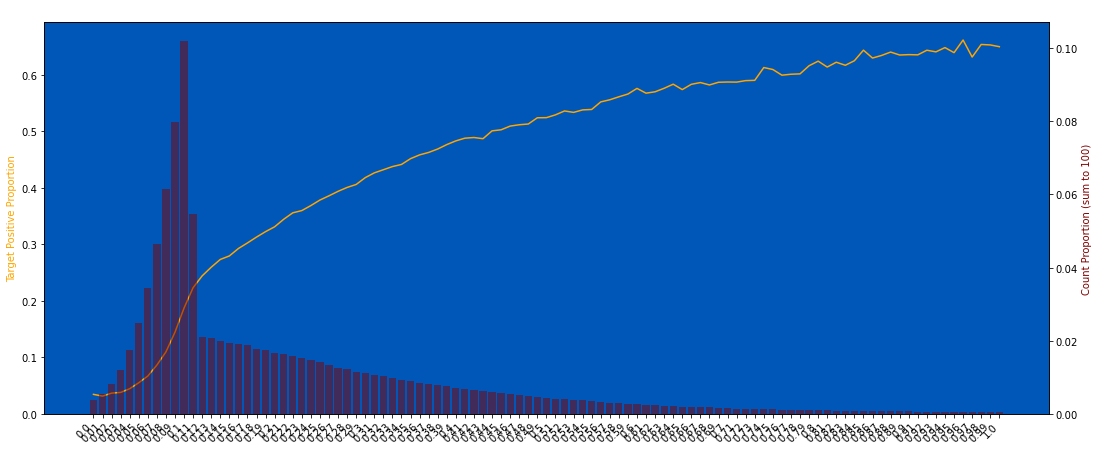

In [54]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


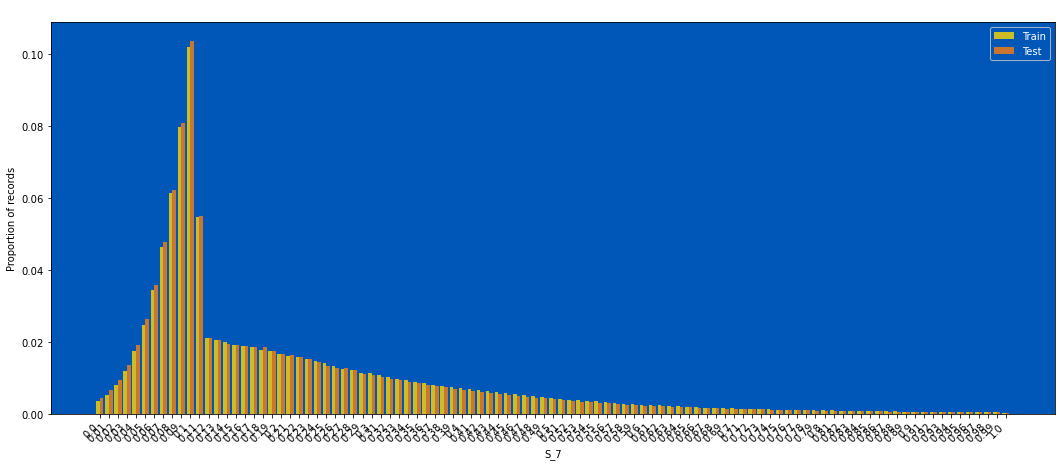

In [55]:
plot_train_test_distribution(train, test, "S_7", nunique_thr=5000)

### S_8

0 null count, 0.000 null proportion
nan of the targets have label = 1


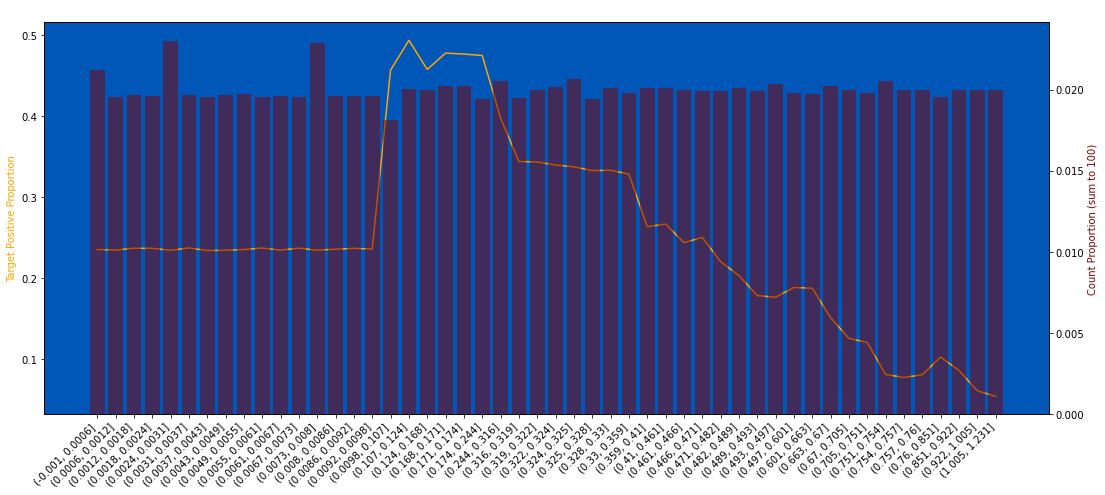

In [56]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [57]:
%%time
train, test = round_dfs(train, test, col="S_8", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 206 ms, sys: 658 ms, total: 864 ms
Wall time: 1.75 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


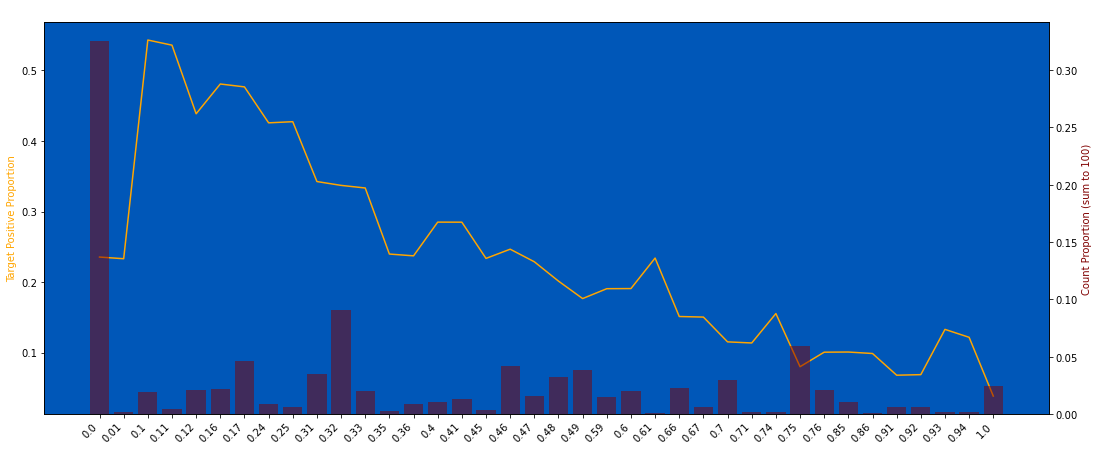

In [58]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

**Comments**
- S_8 in (0, 0.01) is likely to be NaN, because it violates the default rate downward trend & its average default rate is around 25%
- Also, original S_8 has no null values

In [59]:
%%time
train, test = fill_nans(train, test, col="S_8", tuple_of_values=(0, 0.01), add_new_col=False)

CPU times: user 251 ms, sys: 934 ms, total: 1.19 s
Wall time: 296 ms


1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


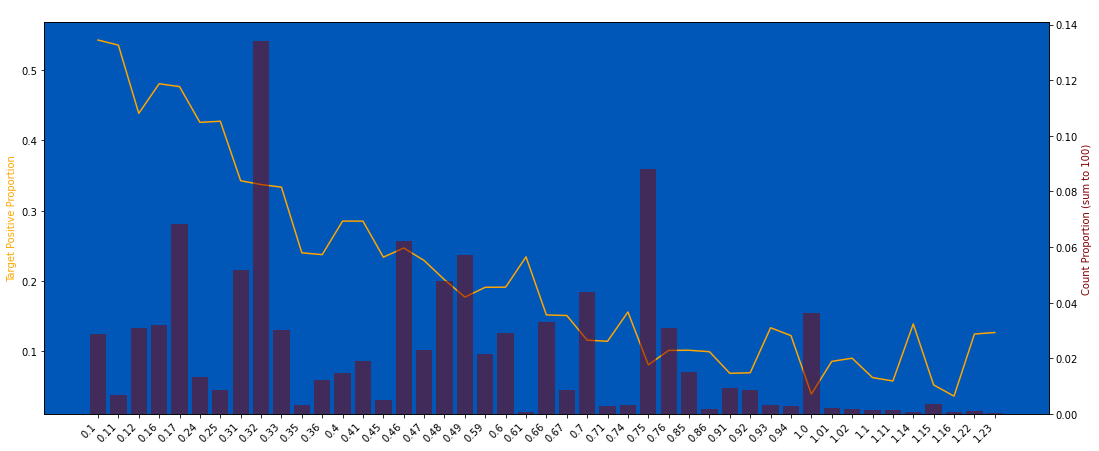

In [60]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


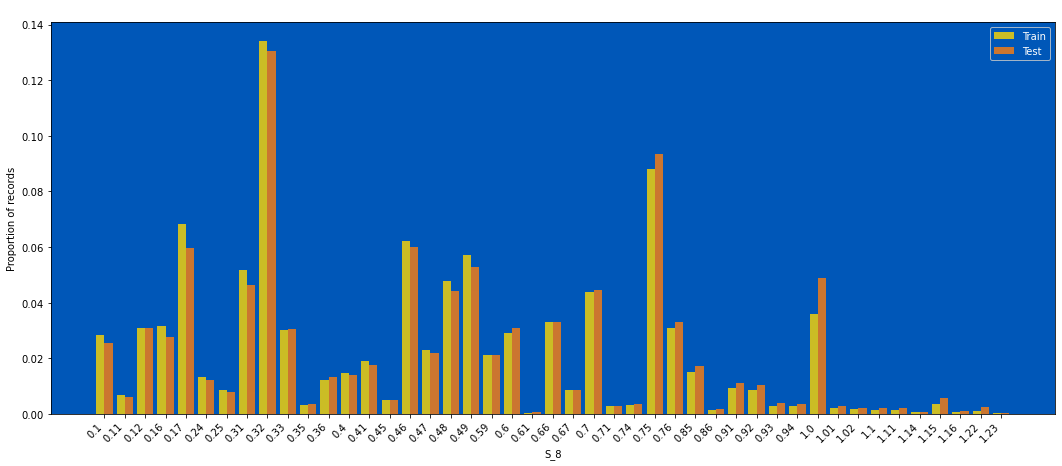

In [61]:
plot_train_test_distribution(train, test, "S_8", nunique_thr=500, without_drop_tail=True)

### S_9

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1


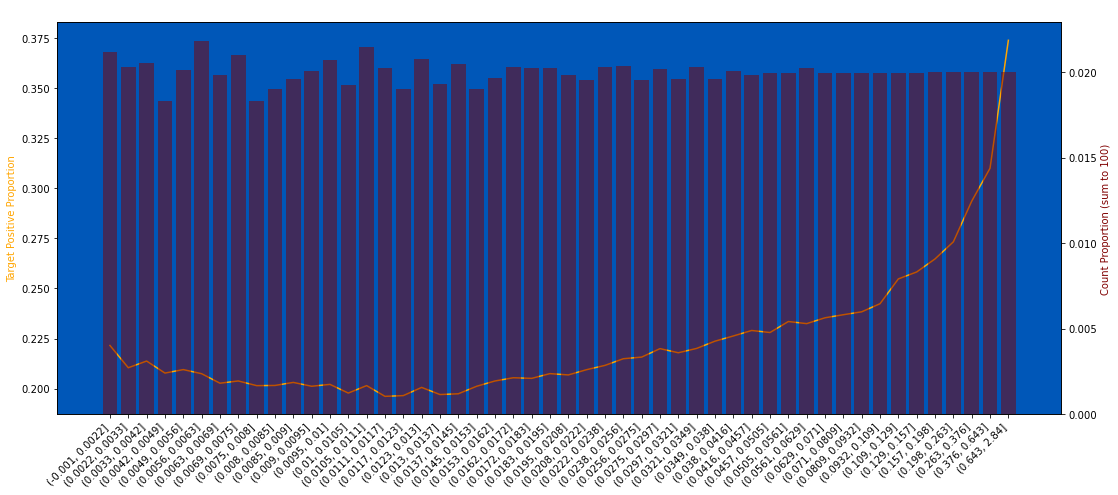

In [62]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [63]:
%%time
train, test = round_dfs(train, test, col="S_9", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 222 ms, sys: 696 ms, total: 918 ms
Wall time: 1.91 s


2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


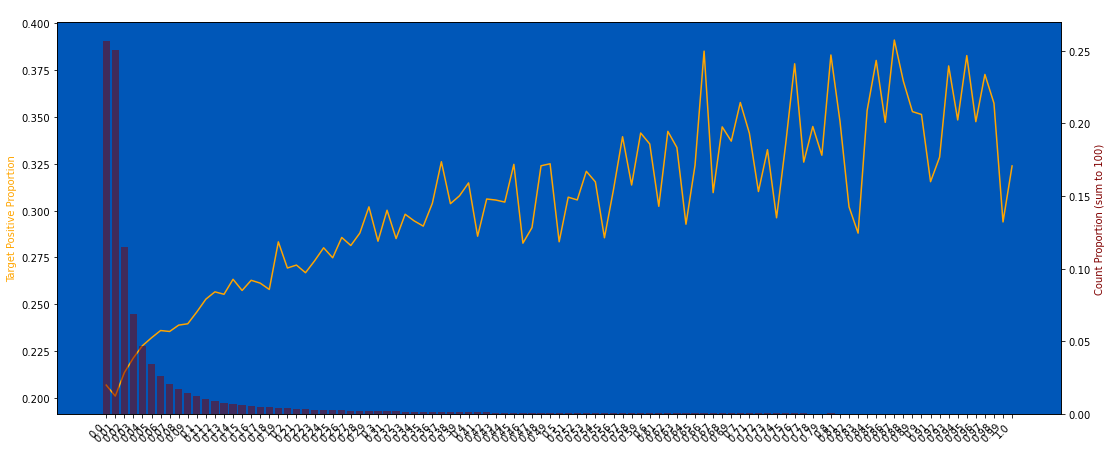

In [64]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True, nunique_thr=300, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


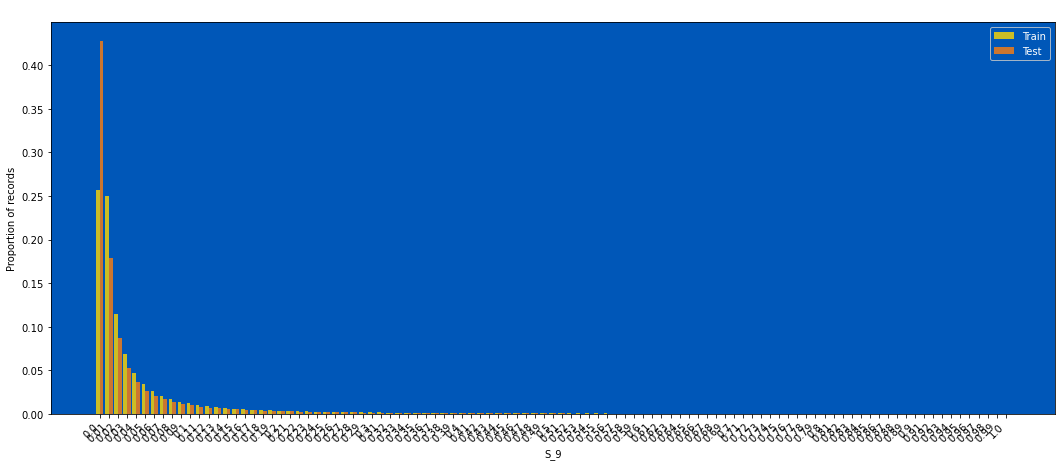

In [65]:
plot_train_test_distribution(train, test, "S_9", nunique_thr=300)

**Train Test Skew: Heavy**

### S_11

0 null count, 0.000 null proportion
nan of the targets have label = 1


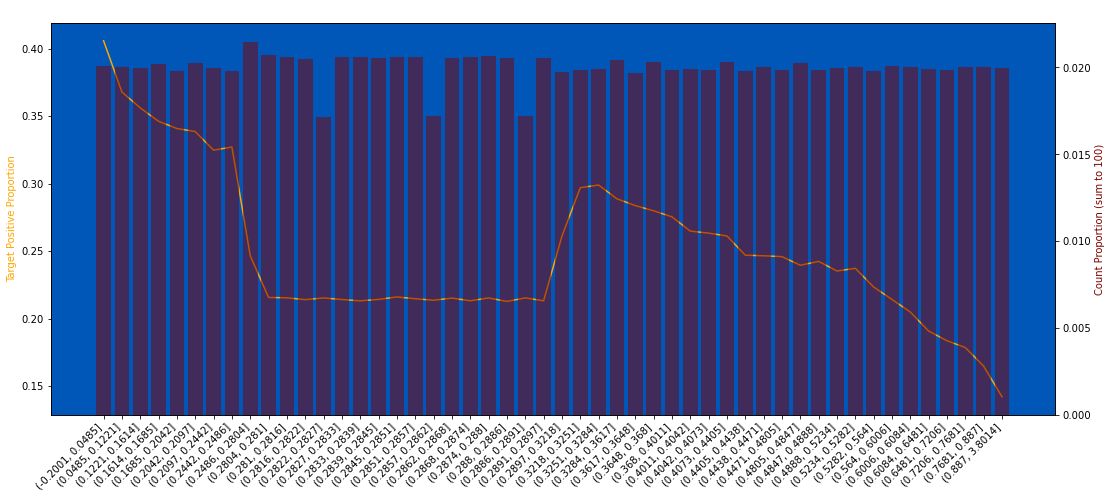

In [66]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True)

In [67]:
train, test = fill_nans(train, test, "S_11", method="range", range_of_values=(0.28, 0.29), add_new_col=False)

In [68]:
train, test = round_dfs(train, test, col="S_11", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


1897968 null count, 0.343 null proportion
0.2144 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


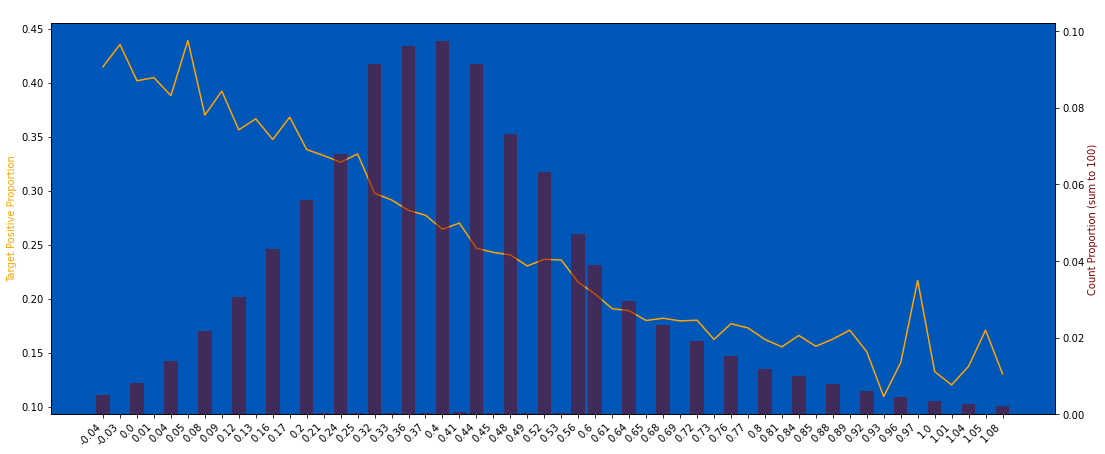

In [69]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


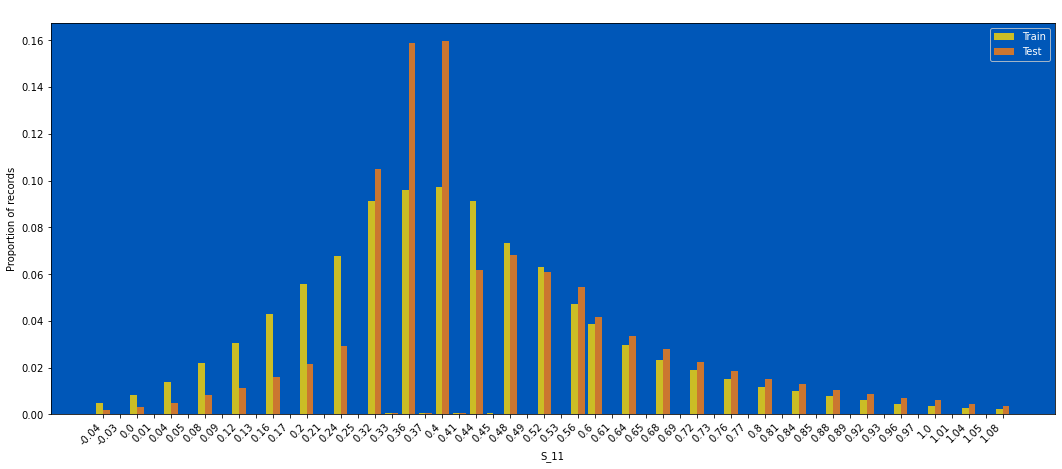

In [70]:
plot_train_test_distribution(train, test, "S_11", nunique_thr=50000)

**Train Test Skew: Heavy**

### S_12

0 null count, 0.000 null proportion
nan of the targets have label = 1


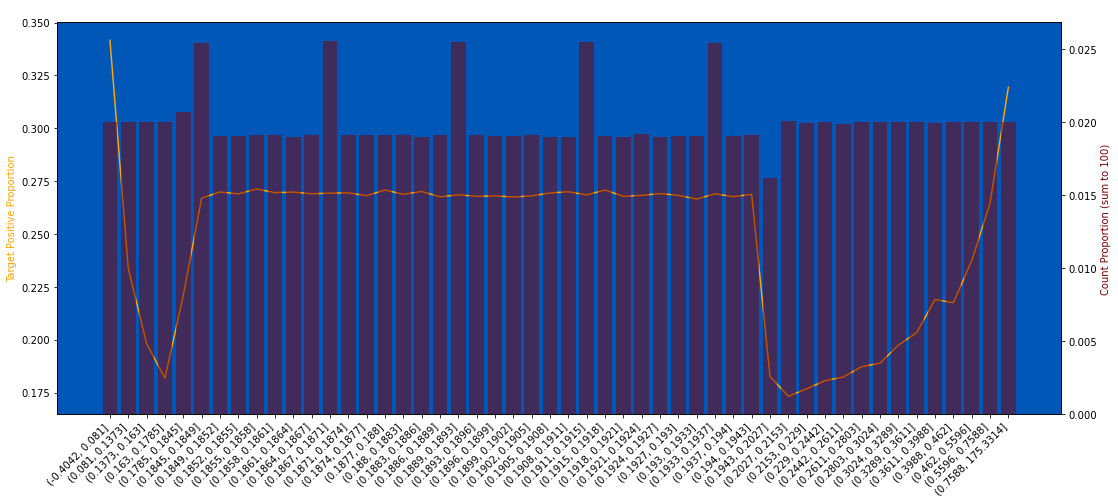

In [71]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [72]:
%%time
train, test = round_dfs(train, test, col="S_12", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 197 ms, sys: 657 ms, total: 854 ms
Wall time: 1.74 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


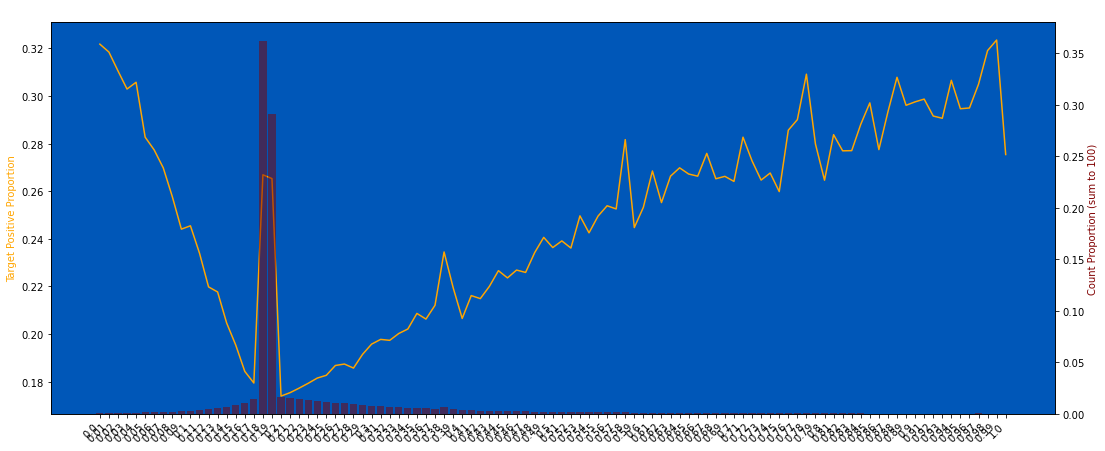

In [73]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [74]:
train["S_12_"] = train["S_12"].copy()
test["S_12_"] = test["S_12"].copy()

In [75]:
train.loc[train["S_12"].between(0.18, 0.19), "S_12_"] = np.nan
test.loc[test["S_12"].between(0.18, 0.19), "S_12_"] = np.nan

In [76]:
for col in train.columns[2:]:
    if col == "temp":
        continue
    corrcoef = train[["S_12_", col]].dropna().corr().iloc[0, 1]
    if abs(corrcoef) >= 0.3:
        print(col, corrcoef)

S_12 1.0
S_12_ 1.0


#### ToDo:
- Replace some of the 0.18 & 0.19 with NaN, need to find the appropriate way to filter the subset to be replace

Bottom 1% and Top 1% are dropped from this chart


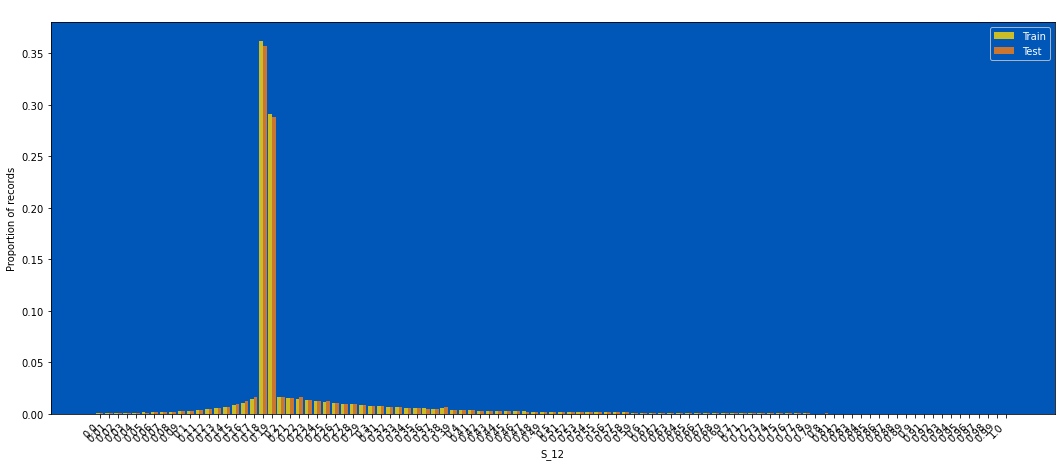

In [77]:
plot_train_test_distribution(train, test, "S_12", nunique_thr=50000)

**Train Test Skew: Mild**

In [78]:
# temp = train.loc[train["S_12"].between(0.18425, 0.19425)]
# plot_target_check(temp, "S_12", q=100, use_raw_bin=True, nunique_thr=2, strfy_x=True)

In [79]:
# train, test = fill_nans(train, test, col="S_12", method="range", range_of_values=(0.1842, 0.1943), add_new_col=False)

In [80]:
# %%time
# train, test = round_dfs(train, test, col="S_12", decimals=2, add_new_col=False)

In [81]:
# s12_summary = plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, return_df=True)

### S_13

0 null count, 0.000 null proportion
nan of the targets have label = 1


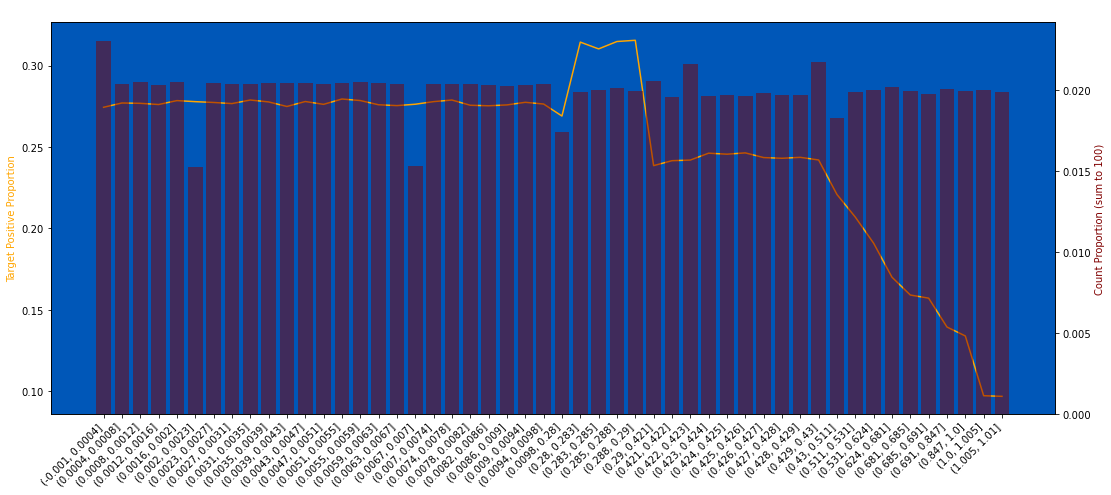

In [82]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

In [83]:
%%time
train, test = round_dfs(train, test, col="S_13", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 209 ms, sys: 668 ms, total: 877 ms
Wall time: 1.77 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


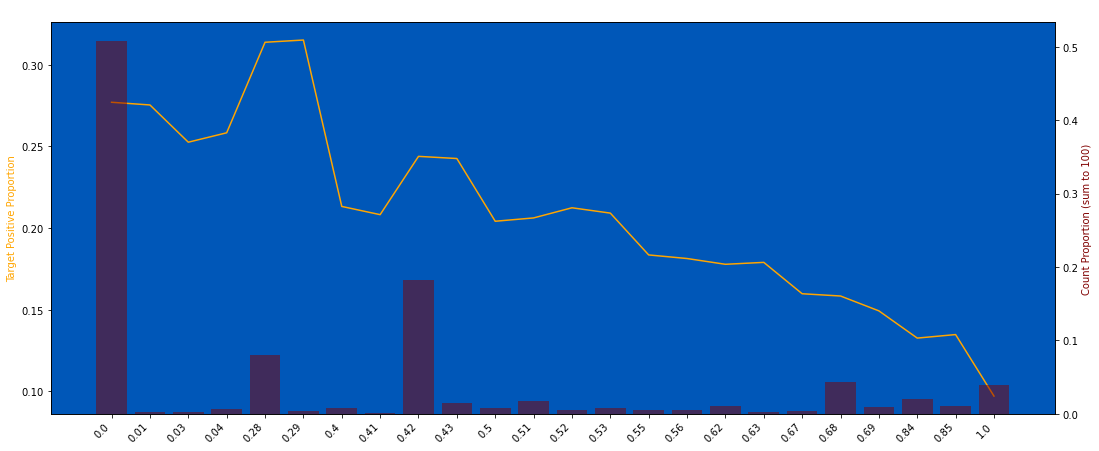

In [84]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

In [85]:
mapping_dict = {
    0.01: 0,
    0.03: 0,
    0.04: 0,
    0.29: 0.28,
    0.41: 0.4,
    0.42: 0.4,
    0.43: 0.4,
    0.5: 0.52,
    0.51: 0.52,
    0.53: 0.52,
    0.55: 0.56,
    0.62: 0.64,
    0.63: 0.64,
    0.67: 0.68,
    0.69: 0.68,
    0.85: 0.84
}

In [86]:
train, test = manual_mapping(train, test, "S_13", mapping_dict, add_new_col=False)

In [87]:
if train["S_13"].nunique() == test["S_13"].nunique():
    train["S_13"] = (train["S_13"] / 0.04).astype(int)
    test["S_13"] = (test["S_13"] / 0.04).astype(int)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


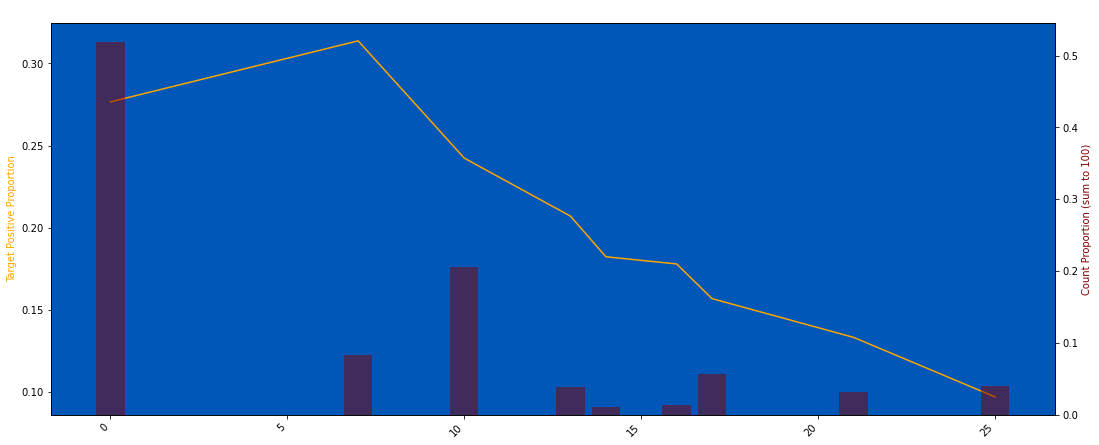

In [88]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500)

In [89]:
train, test = fill_nans(train, test, col="S_13", method="point", tuple_of_values=(0), add_new_col=False)

2873039 null count, 0.519 null proportion
0.2766 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


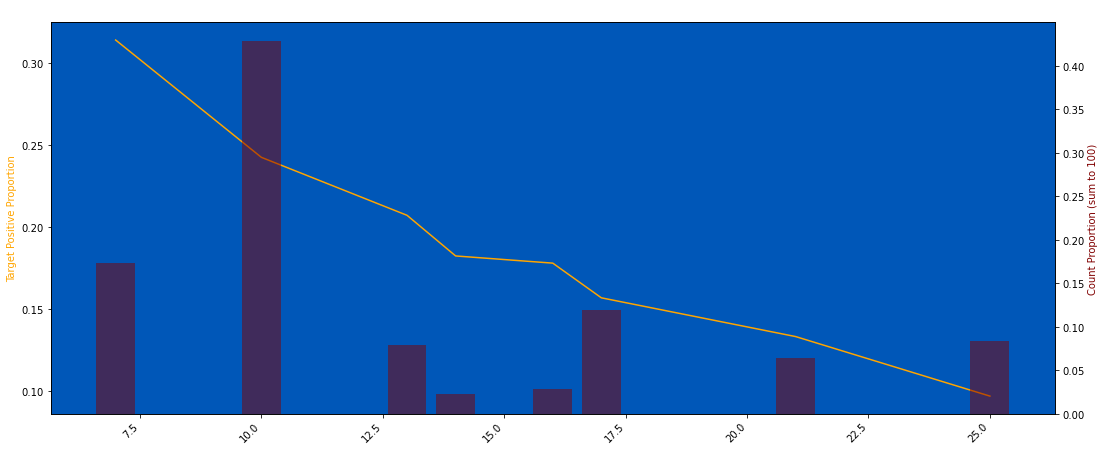

In [90]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500)

Bottom 1% and Top 1% are dropped from this chart


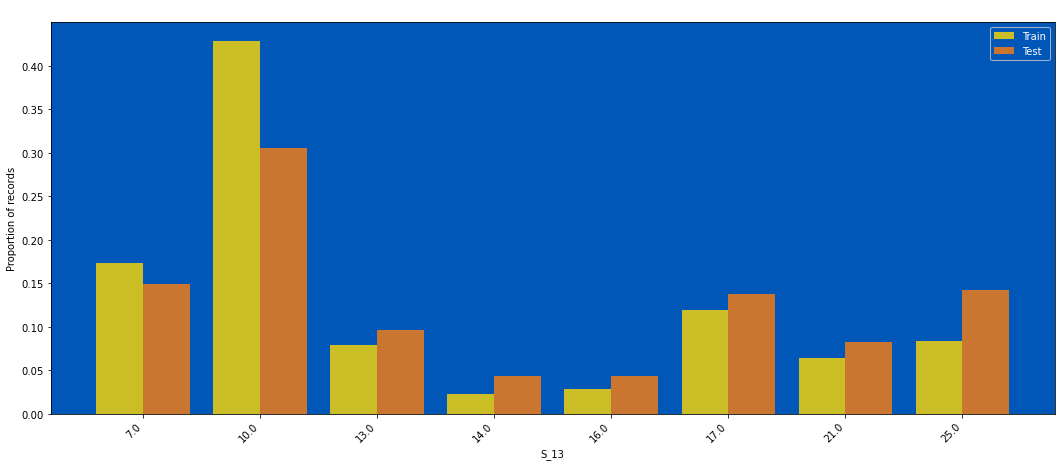

In [91]:
plot_train_test_distribution(train, test, "S_13", nunique_thr=50000)

### S_15

0 null count, 0.000 null proportion
nan of the targets have label = 1


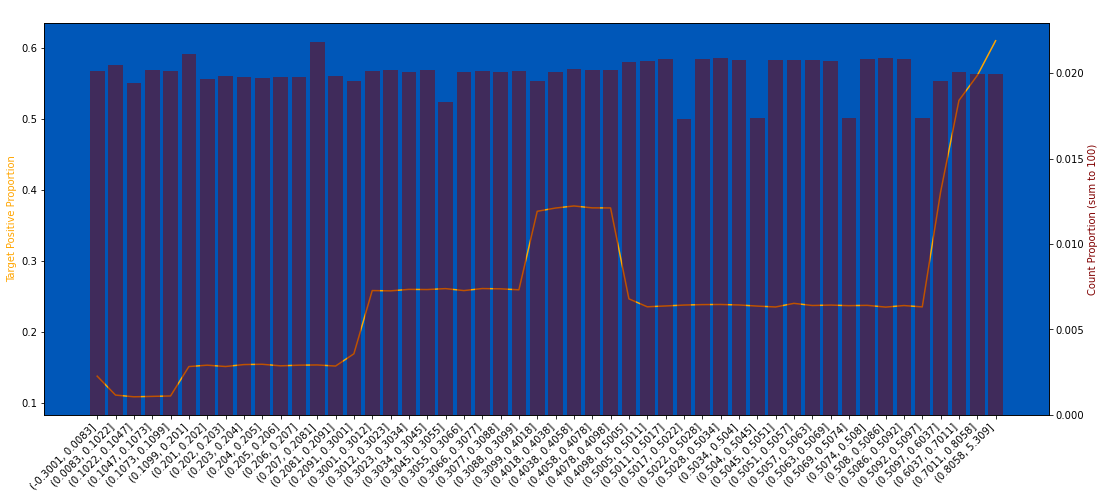

In [92]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True)

In [93]:
%%time
train, test = round_dfs(train, test, col="S_15", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 210 ms, sys: 661 ms, total: 871 ms
Wall time: 1.76 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


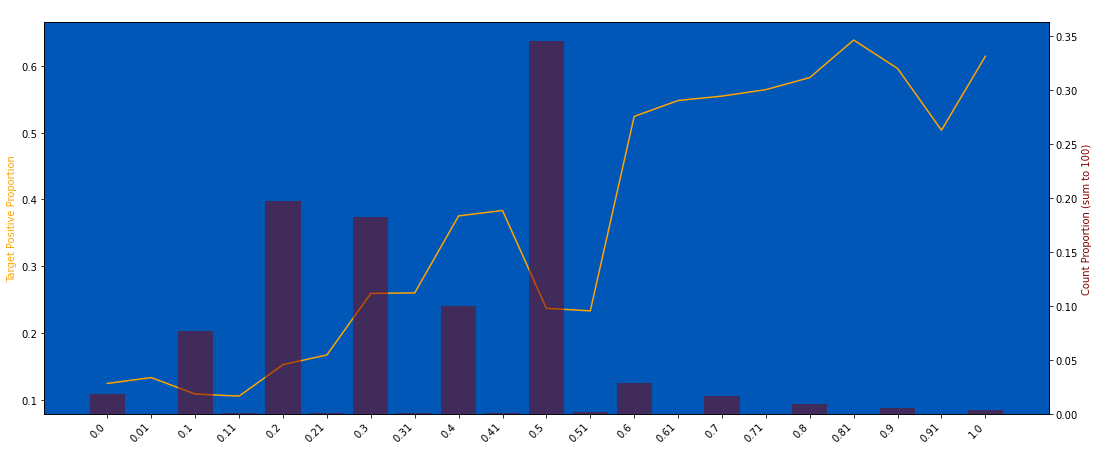

In [94]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

**Comments:**
- Some of the 0.5 - 0.51 are suspiciously null value, reason => violate bell curve & spike in default trend (lower default rate)

In [95]:
train["S_15_"] = train["S_15"].copy()
test["S_15_"] = test["S_15"].copy()

In [96]:
train.loc[train["S_15"].between(0.5, 0.51), "S_15_"] = np.nan
test.loc[test["S_15"].between(0.5, 0.51), "S_15_"] = np.nan

In [97]:
for col in train.columns[2:]:
    if col == "temp":
        continue
    corrcoef = train[["S_15_", col]].dropna().corr().iloc[0, 1]
    if abs(corrcoef) >= 0.3:
        print(col, corrcoef)

P_2 -0.3200026250724117
S_3 0.5140093608756913
S_7 0.46611371980641025
S_8 -0.7195455901403972
S_15 1.0
S_15_ 1.0


**Comments:**
- S_8 has the highest (absolute) correlation with S_15, use this information to cross validate the 0.5 - 0.51

In [98]:
train["S_15"].describe()

count   5,531,451.0000
mean            0.3698
std             0.1951
min            -0.3000
25%             0.2000
50%             0.4000
75%             0.5000
max             5.3000
Name: S_15, dtype: float64

In [99]:
train.loc[train["S_8"].isnull(), "S_15"].describe()

count   1,808,480.0000
mean            0.5212
std             0.1140
min             0.5000
25%             0.5000
50%             0.5000
75%             0.5000
max             5.3000
Name: S_15, dtype: float64

In [100]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 93)

0.51

**Comments:**
- When S_8 is null, S_15 is likely to be 0.5 (about 93% of them)
- Replace those S_15 (0.5 - 0.51) with NaN

In [101]:
train.loc[(train["S_15"].between(0.5, 0.51)) & (train["S_8"].isnull()), "S_15"] = np.nan
test.loc[(test["S_15"].between(0.5, 0.51)) & (test["S_8"].isnull()), "S_15"] = np.nan

In [102]:
train, test = round_dfs(train, test, col="S_15", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


1689649 null count, 0.305 null proportion
0.2090 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


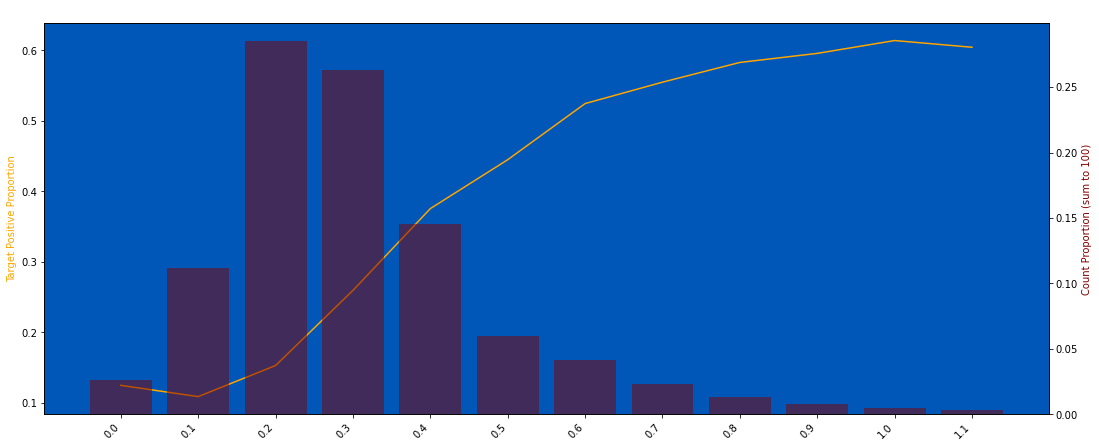

In [103]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


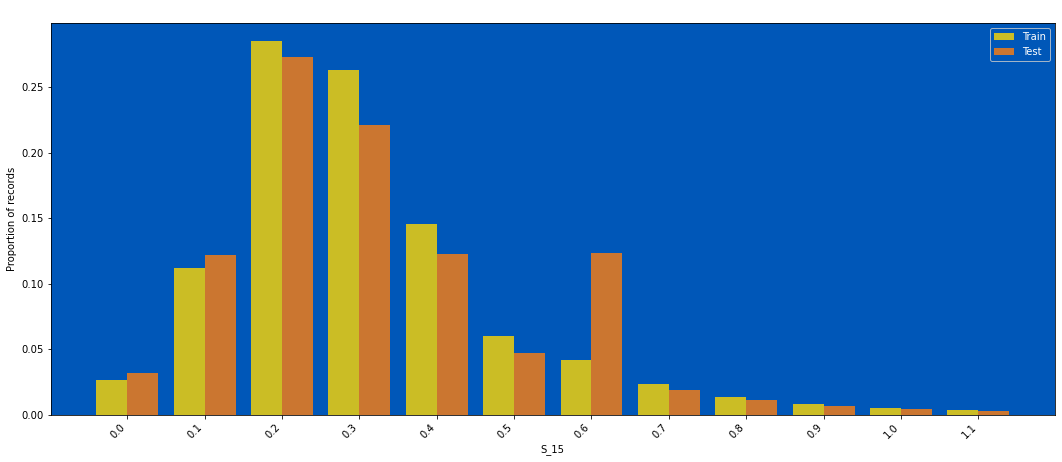

In [104]:
plot_train_test_distribution(train, test, "S_15", nunique_thr=500)

In [105]:
train.loc[(train["S_15"].between(0.6, 0.61)) & (train["S_8"].isnull()), "S_15"] = np.nan
test.loc[(test["S_15"].between(0.6, 0.61)) & (test["S_8"].isnull()), "S_15"] = np.nan

Bottom 1% and Top 1% are dropped from this chart


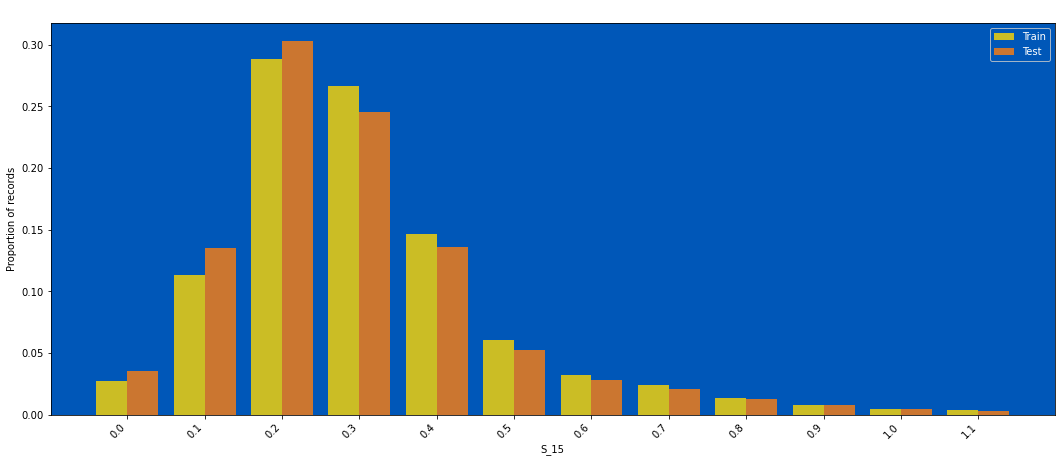

In [106]:
plot_train_test_distribution(train, test, "S_15", nunique_thr=500)

### S_16

0 null count, 0.000 null proportion
nan of the targets have label = 1


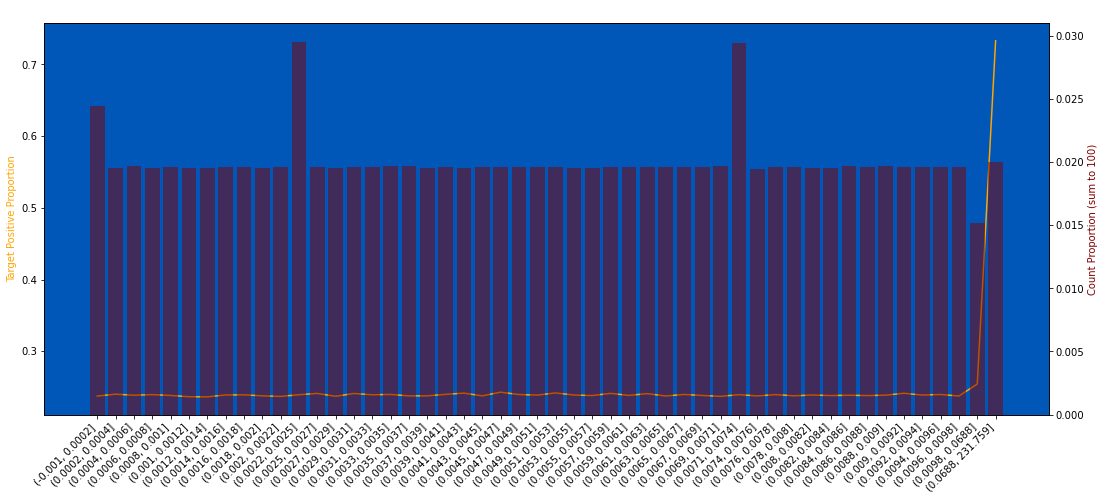

In [107]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [108]:
%%time
train, test = round_dfs(train, test, col="S_16", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 206 ms, sys: 669 ms, total: 876 ms
Wall time: 1.78 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


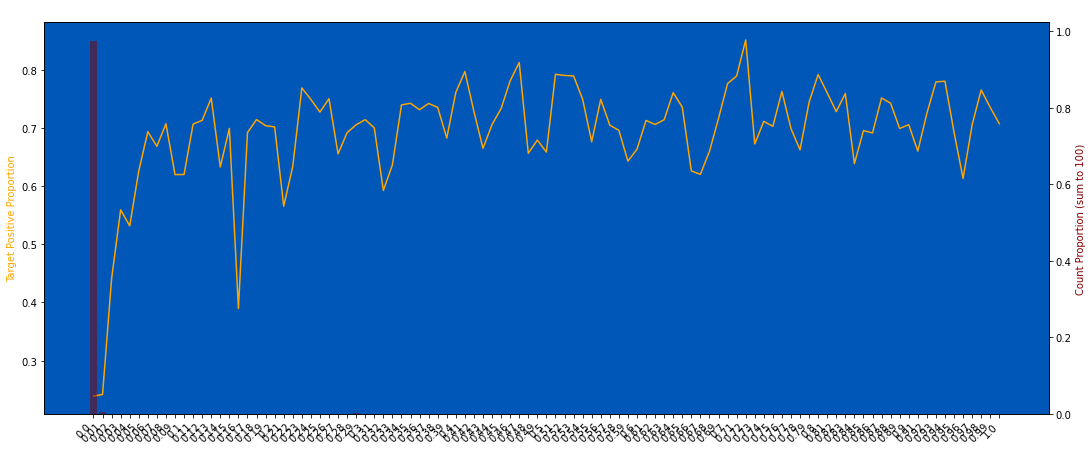

In [109]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


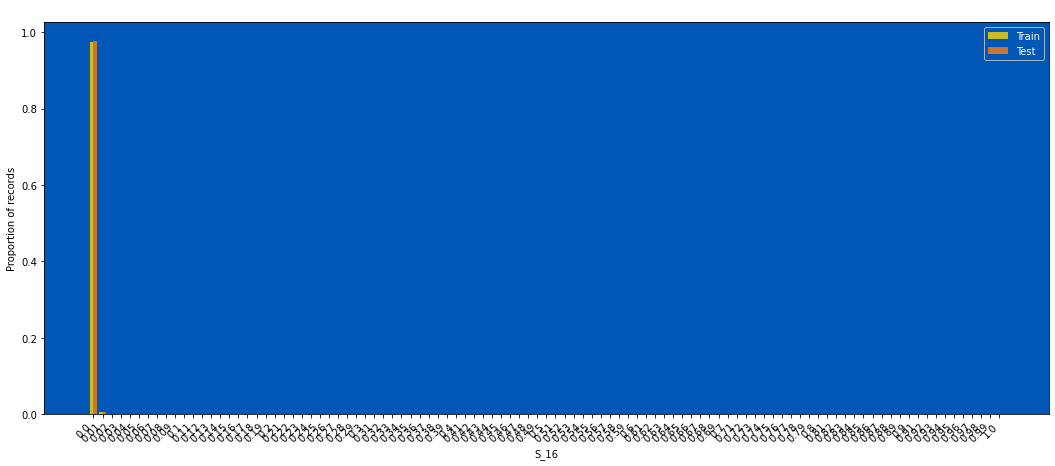

In [110]:
plot_train_test_distribution(train, test, "S_16", nunique_thr=5000)

### S_17

0 null count, 0.000 null proportion
nan of the targets have label = 1


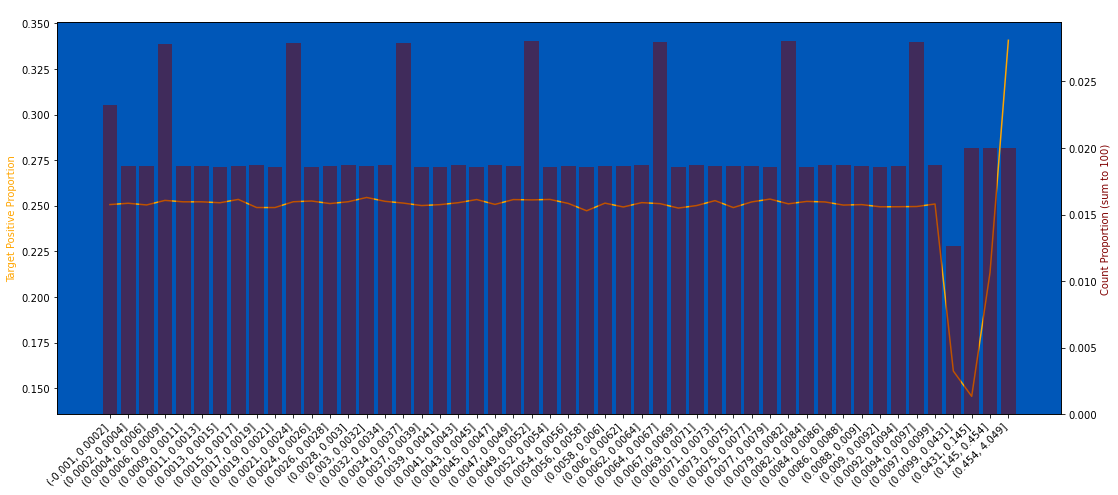

In [111]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [112]:
%%time
train, test = round_dfs(train, test, col="S_17", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 201 ms, sys: 687 ms, total: 887 ms
Wall time: 1.78 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


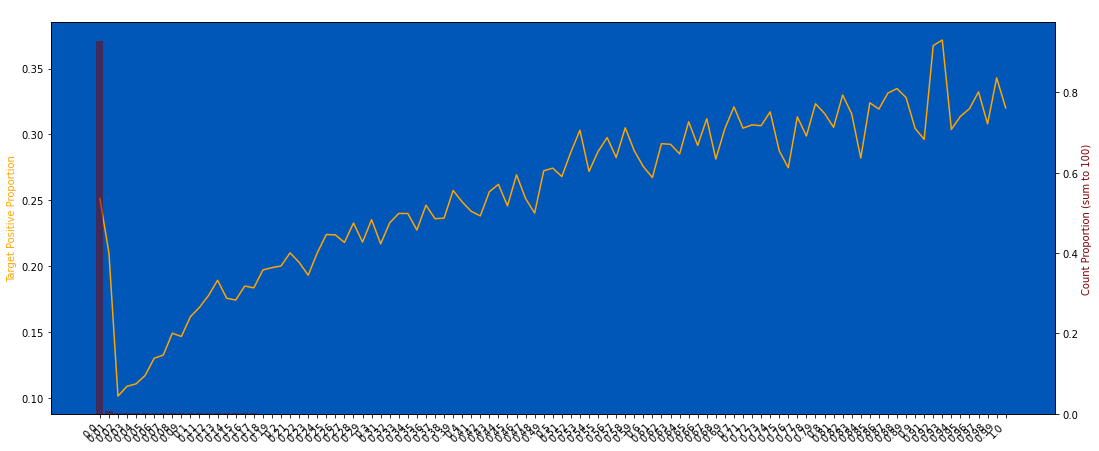

In [113]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [114]:
train, test = fill_nans(train, test, col="S_17", method="point", tuple_of_values=(0, 0.01), add_new_col=False)

5165368 null count, 0.934 null proportion
0.2511 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


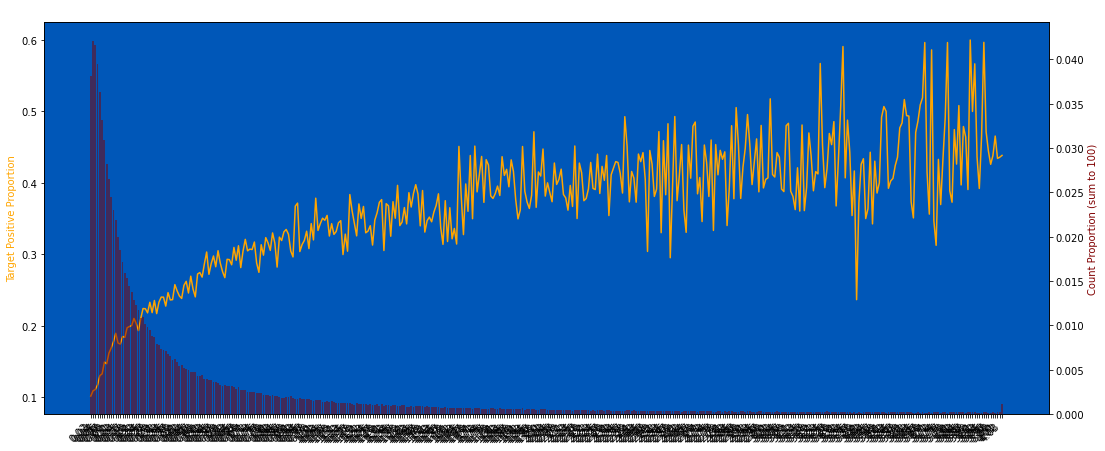

In [115]:
s17_summary = plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


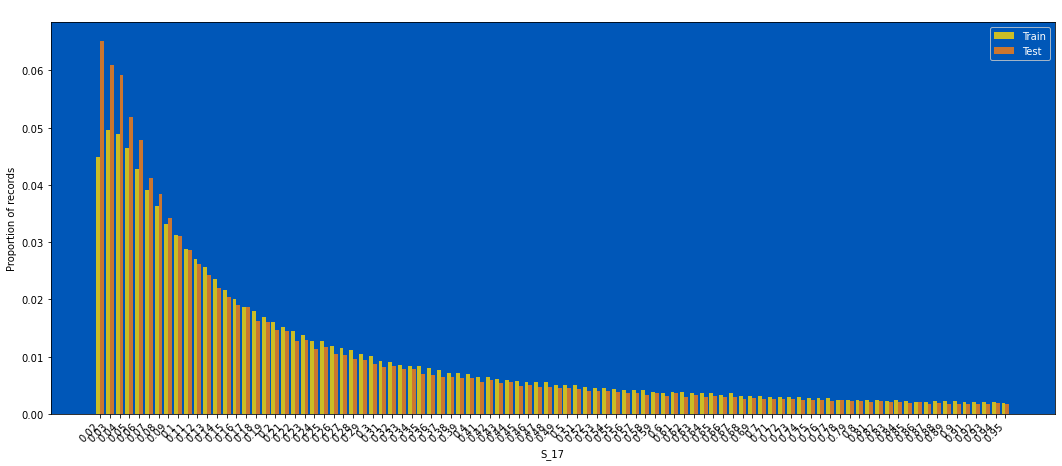

In [116]:
plot_train_test_distribution(
    train.loc[train["S_17"] <= 1], 
    test.loc[test["S_17"] <= 1], 
    "S_17", 
    nunique_thr=15000
)

**Train Test Skew: Heavy**

### S_18

0 null count, 0.000 null proportion
nan of the targets have label = 1


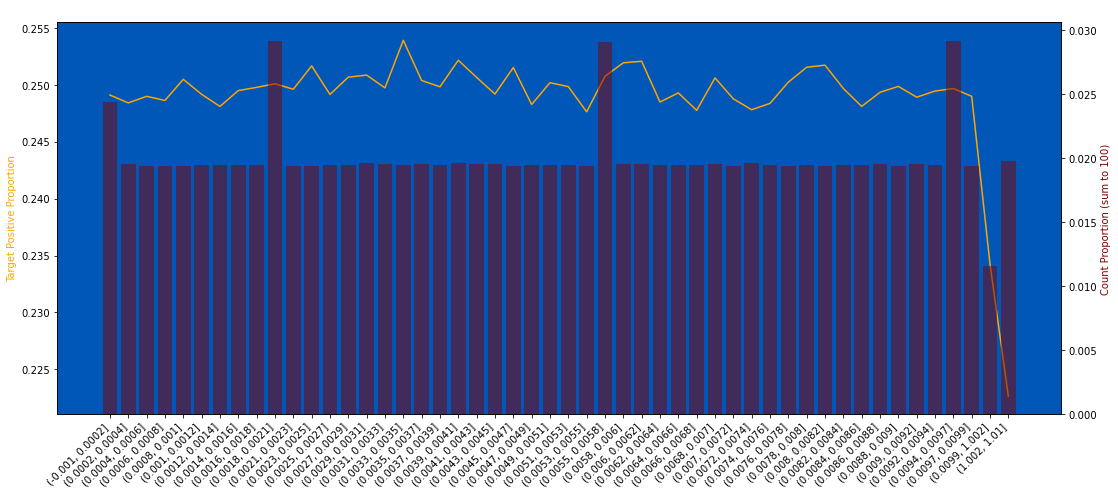

In [117]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True)

In [118]:
%%time
train, test = round_dfs(train, test, col="S_18", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 230 ms, sys: 694 ms, total: 924 ms
Wall time: 1.84 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


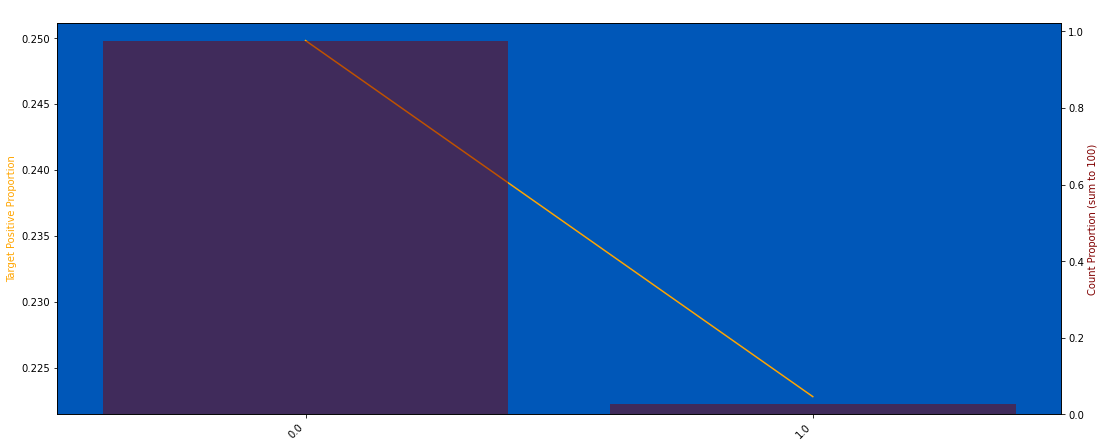

In [119]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


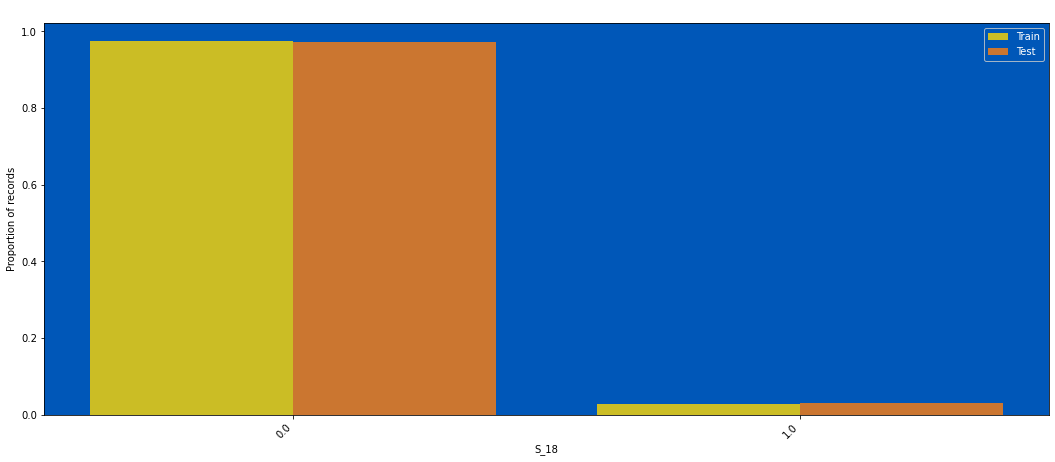

In [120]:
plot_train_test_distribution(train, test, "S_18", nunique_thr=150)

### S_19

0 null count, 0.000 null proportion
nan of the targets have label = 1


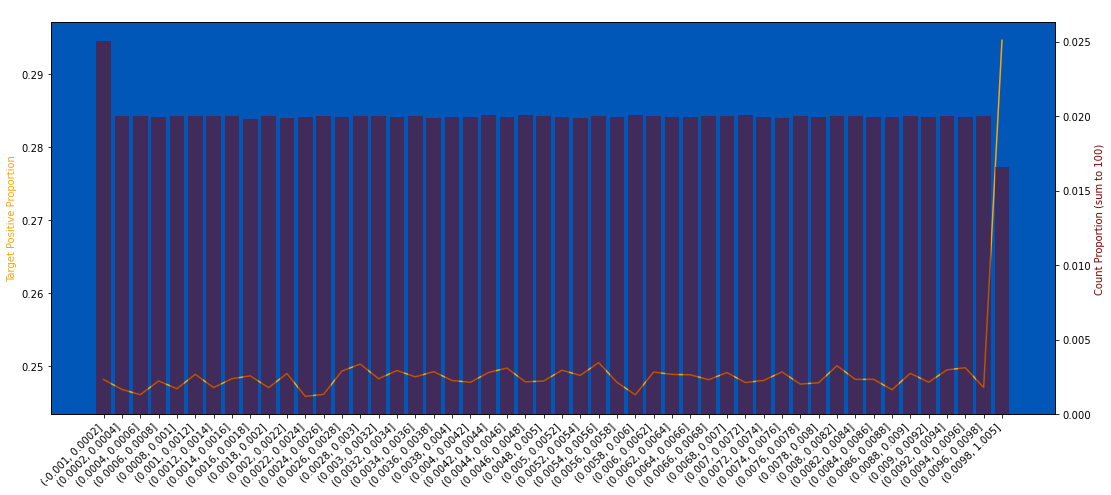

In [121]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [122]:
%%time
train, test = round_dfs(train, test, col="S_19", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 244 ms, sys: 750 ms, total: 993 ms
Wall time: 1.91 s


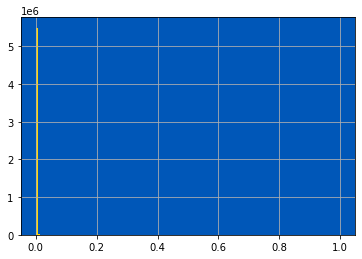

In [123]:
train["S_19"].hist(bins=150)
plt.show()

In [124]:
%%time
train = train.drop(columns=["S_19"], errors="ignore")
test = test.drop(columns=["S_19"], errors="ignore")

CPU times: user 866 ms, sys: 2.71 s, total: 3.58 s
Wall time: 2.49 s


### S_20

0 null count, 0.000 null proportion
nan of the targets have label = 1


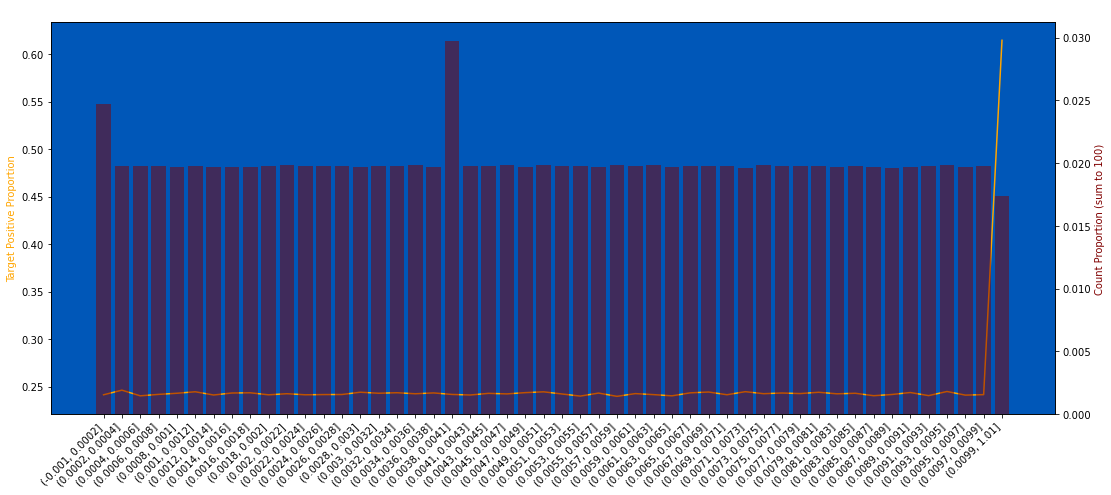

In [125]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=200)

In [126]:
%%time
train, test = round_dfs(train, test, col="S_20", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 262 ms, sys: 818 ms, total: 1.08 s
Wall time: 2 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


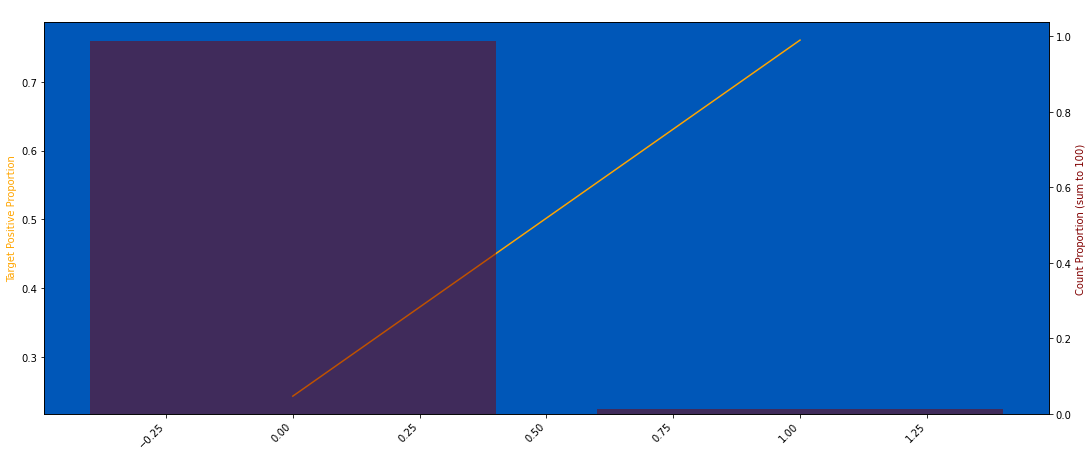

In [127]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=2000)

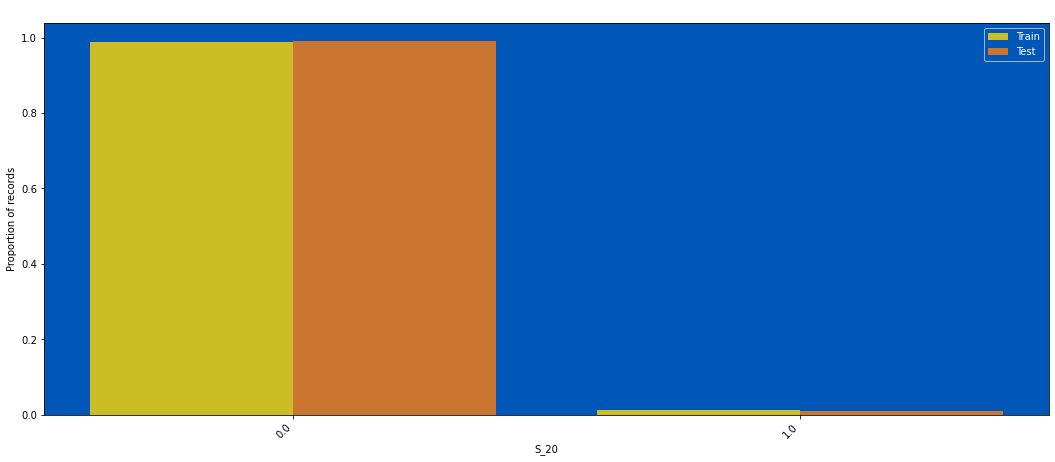

In [128]:
plot_train_test_distribution(train, test, "S_20", nunique_thr=50)

### S_22

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1


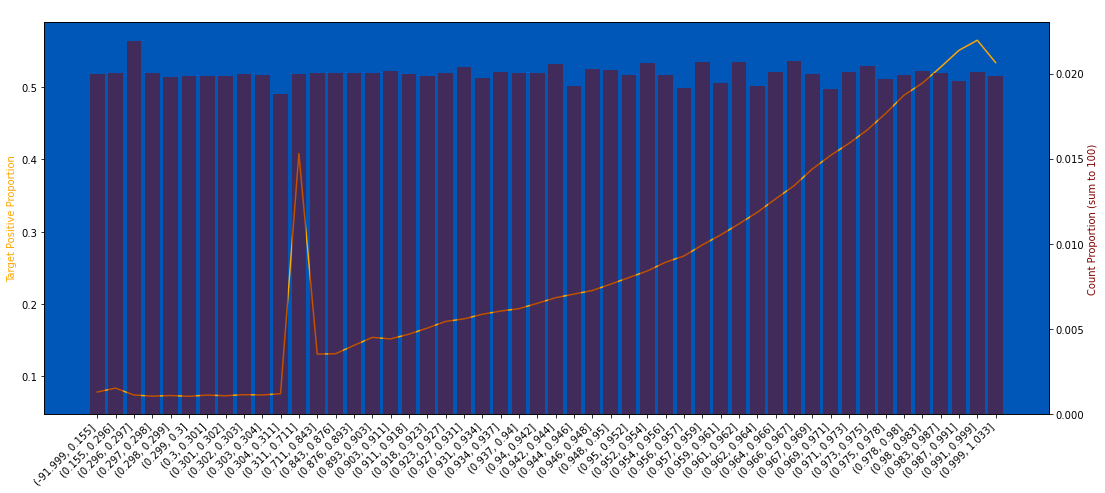

In [129]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True)

In [130]:
%%time
train, test = round_dfs(train, test, col="S_22", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 238 ms, sys: 747 ms, total: 985 ms
Wall time: 1.92 s


19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


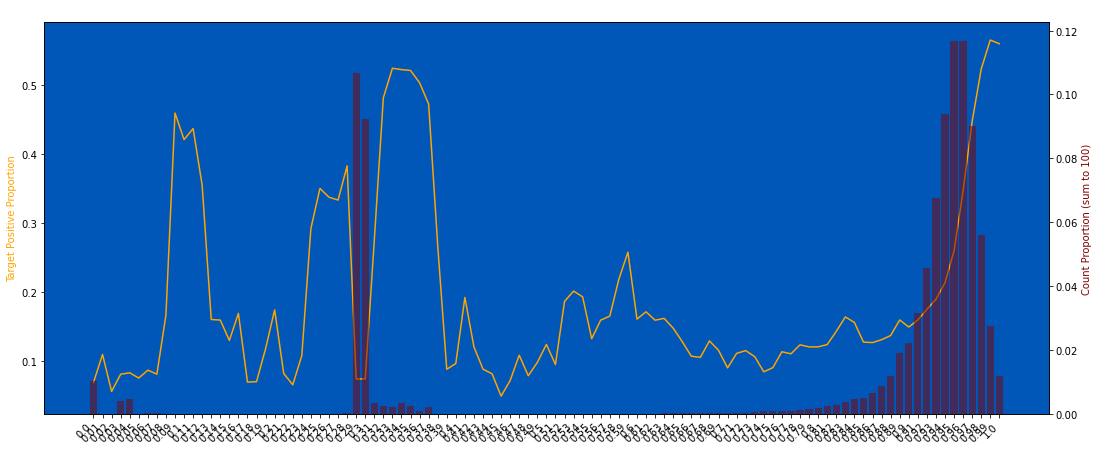

In [131]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True, nunique_thr=777, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


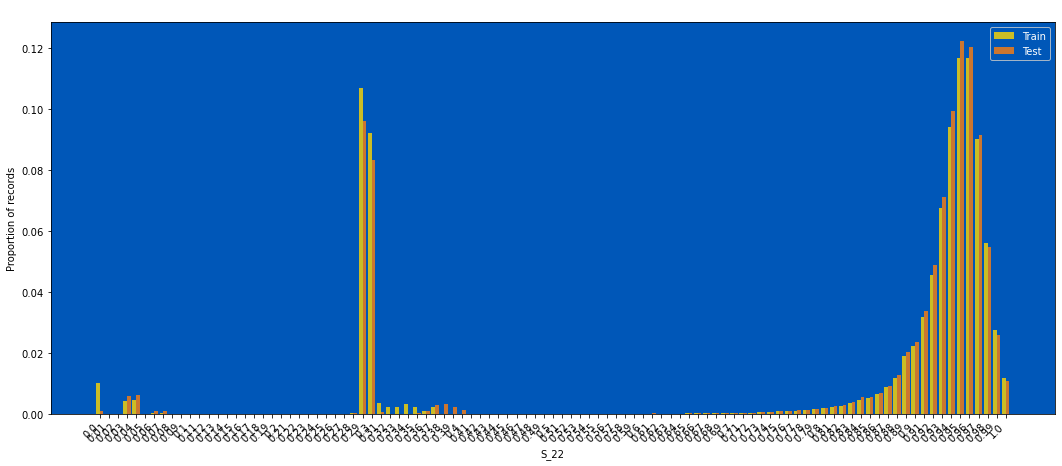

In [132]:
plot_train_test_distribution(train, test, "S_22", nunique_thr=777)

**Comments:**
- Relationship is ambigious

### S_23

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


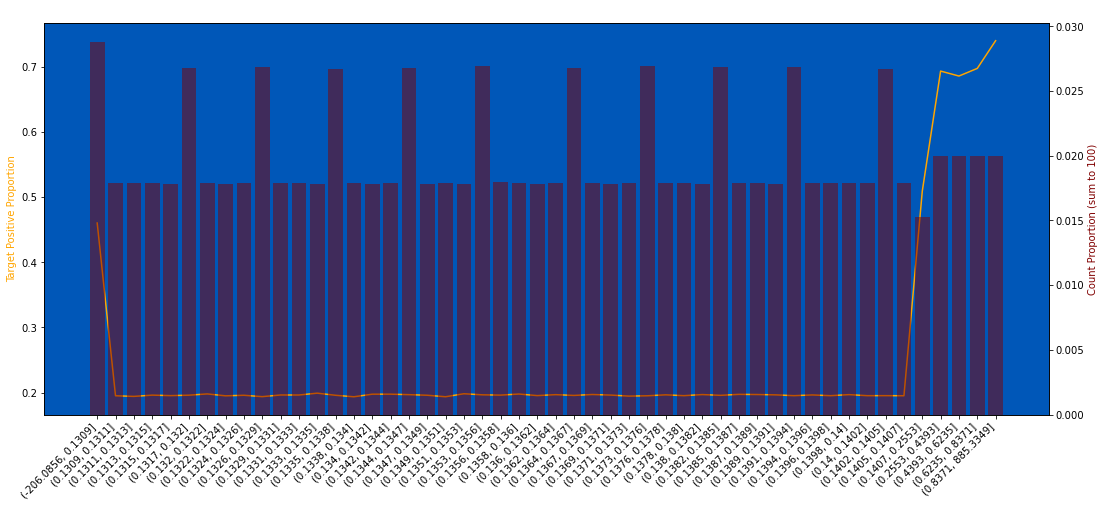

In [133]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [134]:
%%time
train, test = round_dfs(train, test, col="S_23", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 229 ms, sys: 762 ms, total: 990 ms
Wall time: 1.91 s


445 null count, 0.000 null proportion
0.5236 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


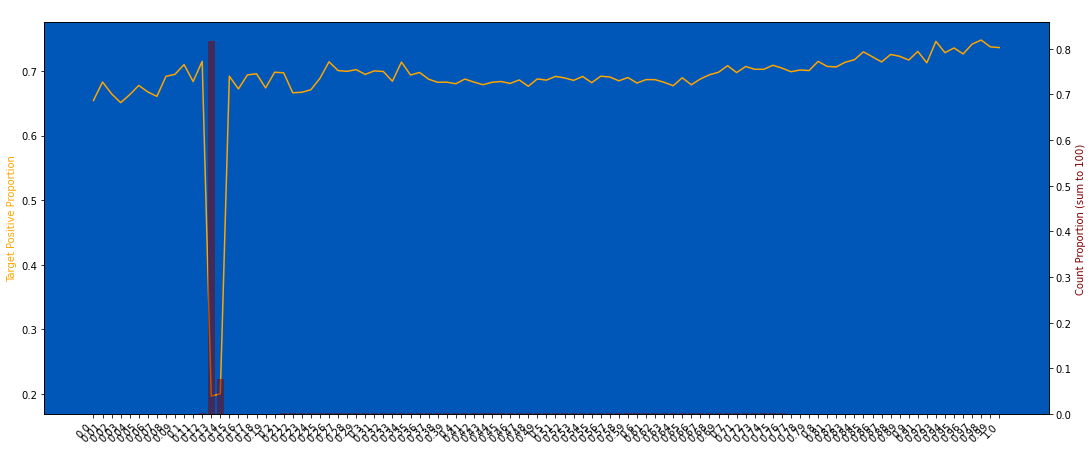

In [135]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

In [136]:
train["S_23_"] = train["S_23"].copy()
test["S_23_"] = test["S_23"].copy()

In [137]:
train.loc[train["S_23"].between(0.13, 0.141), "S_23_"] = np.nan
test.loc[test["S_23"].between(0.13, 0.141), "S_23_"] = np.nan

In [138]:
for col in train.columns[2:]:
    if col == "temp":
        continue
    corrcoef = train[["S_23_", col]].dropna().corr().iloc[0, 1]
    if abs(corrcoef) >= 0.3:
        print(col, corrcoef)

S_22 -0.4953589892356956
S_23 1.0
S_24 -0.6026397187360626
S_25 0.45119221599647313
S_23_ 1.0


**Comments:**
- S_24 has the highest (absolute) correlation with S_23, use this information to cross validate the 0.13 to 0.14

**ToDo:**
- Identify the subset of 0.13 & 0.14 to be replace by NaN

Bottom 1% and Top 1% are dropped from this chart


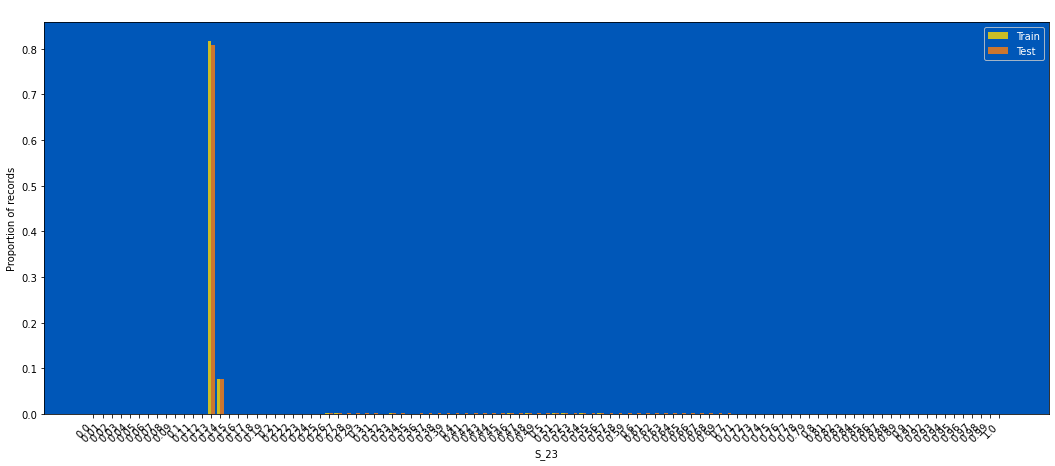

In [139]:
plot_train_test_distribution(train, test, "S_23", nunique_thr=1600)

### S_24

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


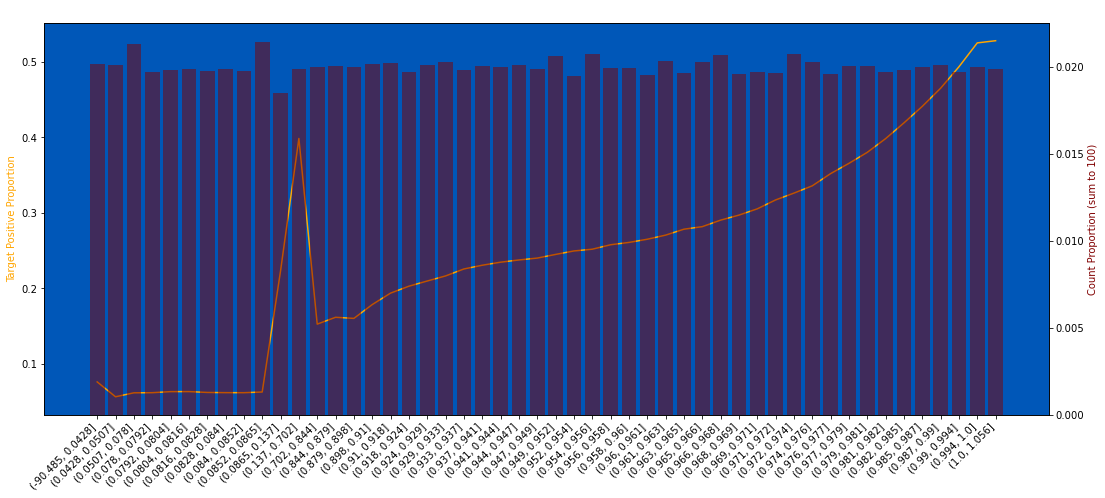

In [140]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [141]:
%%time
train, test = round_dfs(train, test, col="S_24", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 248 ms, sys: 786 ms, total: 1.03 s
Wall time: 1.93 s


18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


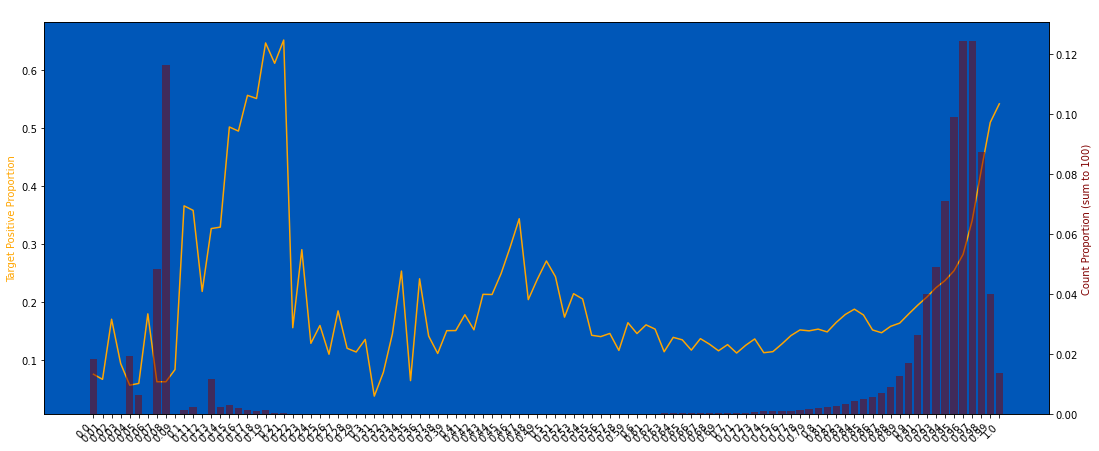

In [142]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True, nunique_thr=650, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


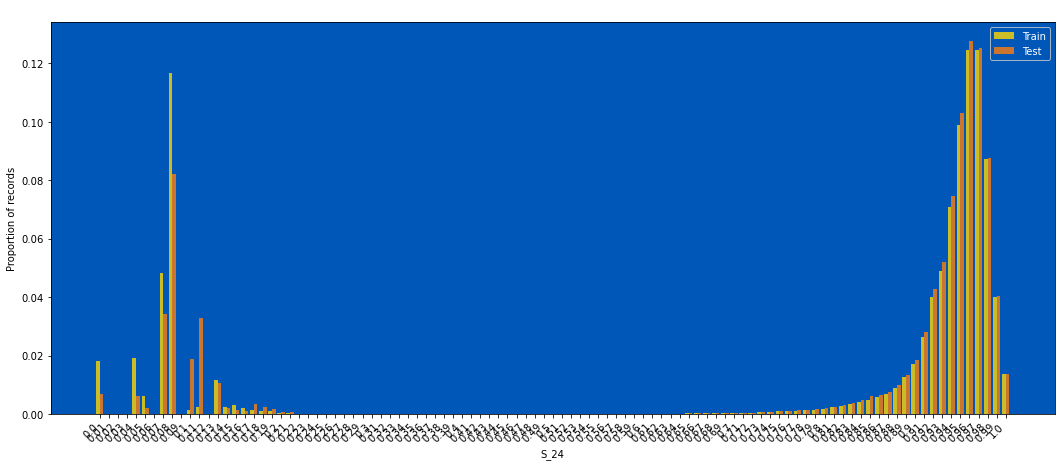

In [143]:
plot_train_test_distribution(train, test, "S_24", nunique_thr=650)

**Train Test Skew: Heavy**

### S_25

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


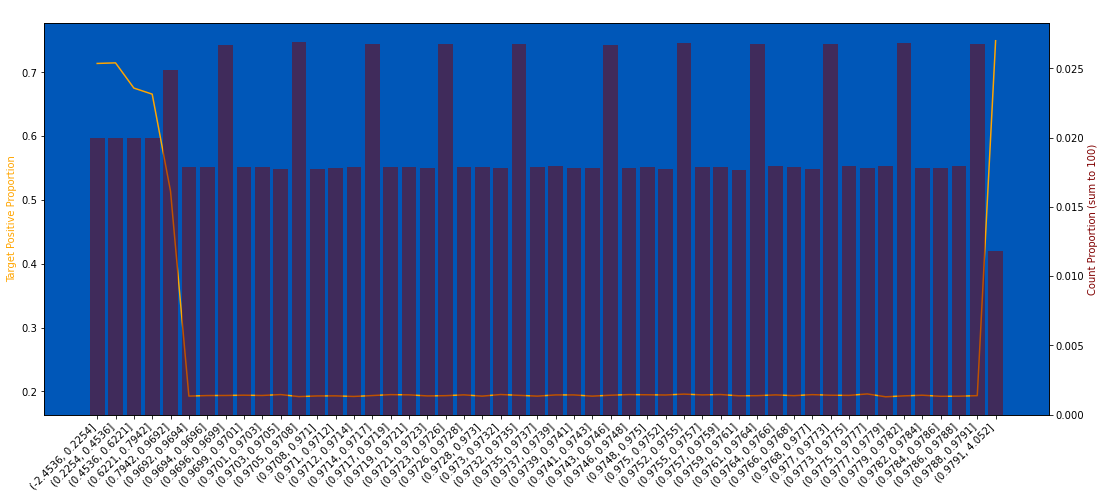

In [144]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [145]:
%%time
train, test = round_dfs(train, test, col="S_25", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 225 ms, sys: 773 ms, total: 998 ms
Wall time: 1.9 s


12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


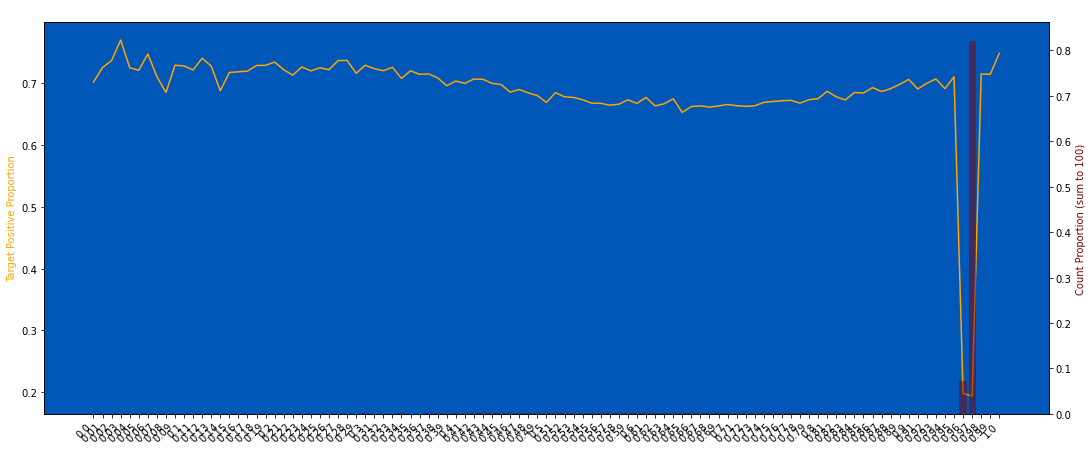

In [146]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


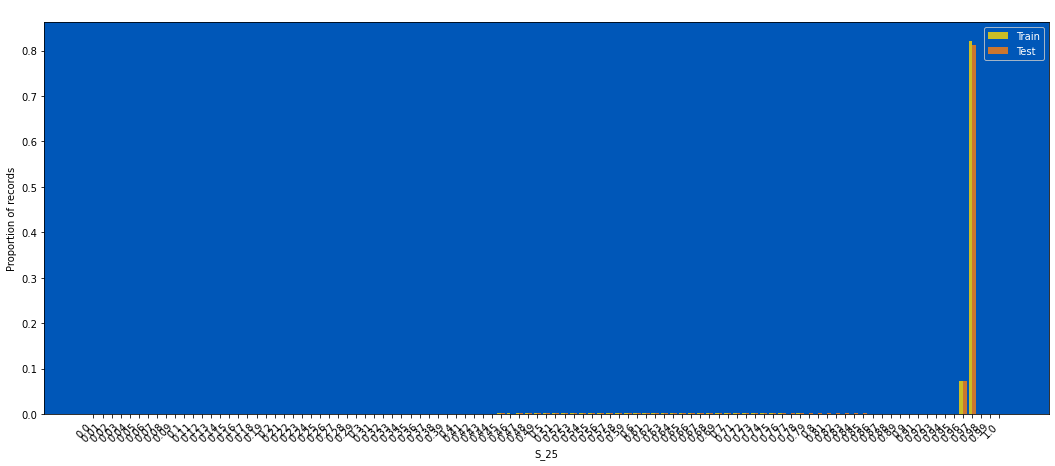

In [147]:
plot_train_test_distribution(train, test, "S_25", nunique_thr=1500)

**Train Test Skew: Moderate**

**ToDo:**
- Identify the subset of 0.97 & 0.98 to be replace by NaN

### S_26

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


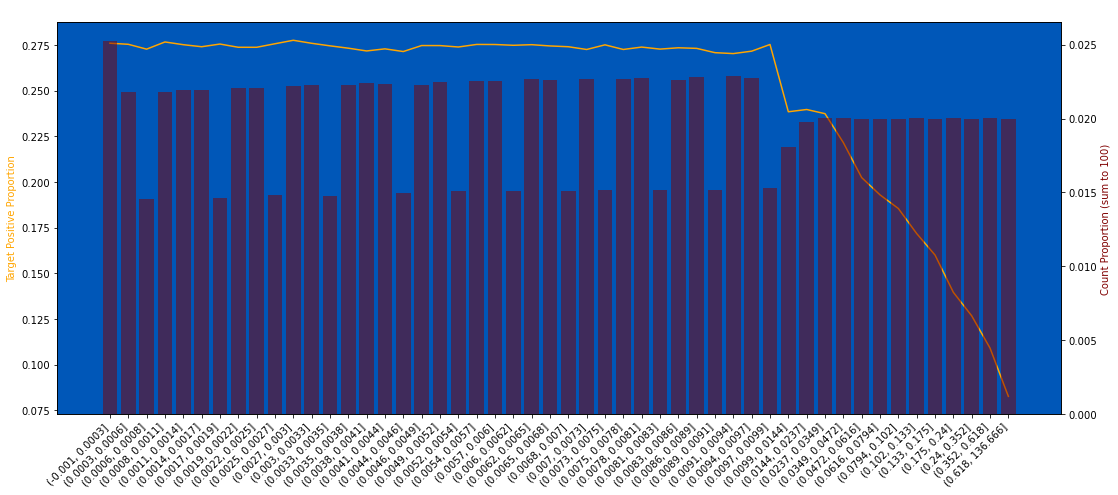

In [148]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [149]:
%%time
train, test = round_dfs(train, test, col="S_26", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 224 ms, sys: 804 ms, total: 1.03 s
Wall time: 1.93 s


634 null count, 0.000 null proportion
0.1325 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


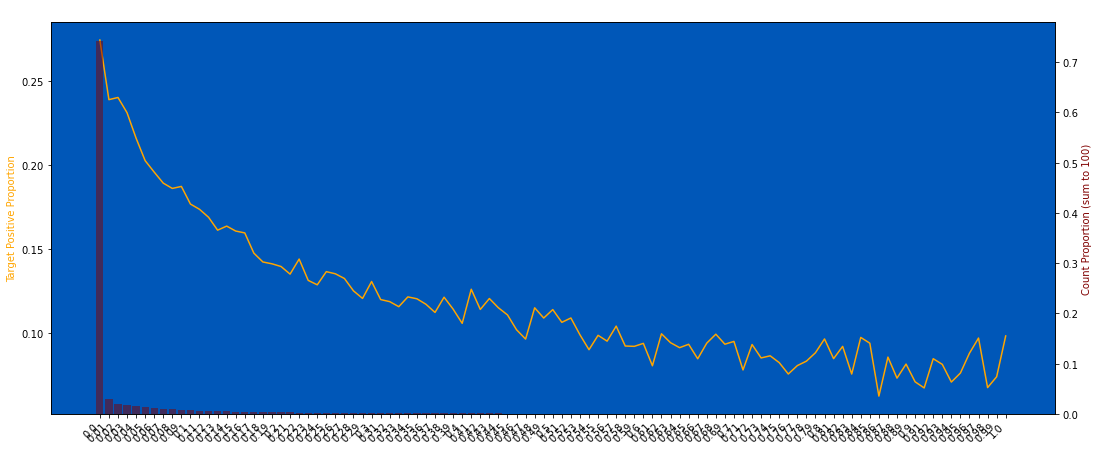

In [150]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


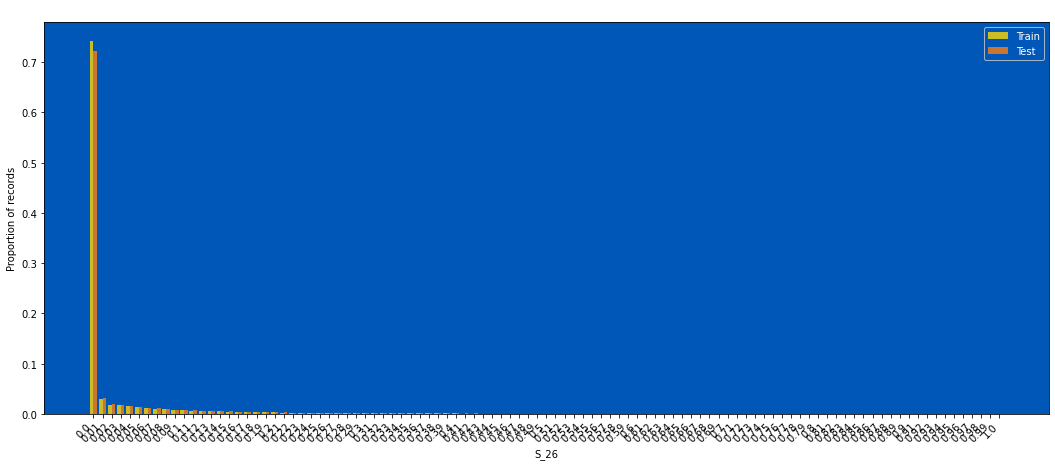

In [151]:
plot_train_test_distribution(train, test, "S_26", nunique_thr=2000)

### S_27

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


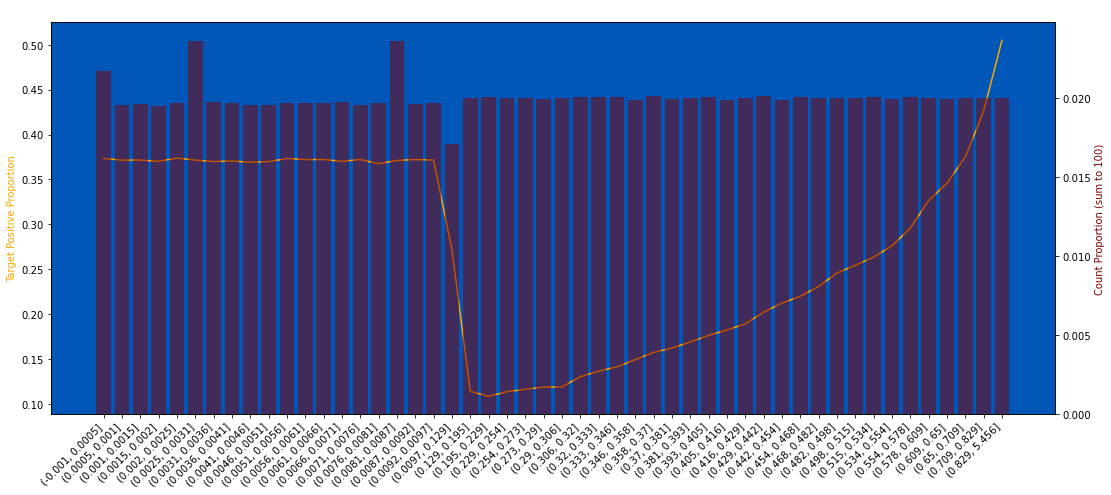

In [152]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [153]:
%%time
train, test = round_dfs(train, test, col="S_27", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 215 ms, sys: 790 ms, total: 1.01 s
Wall time: 1.97 s


1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


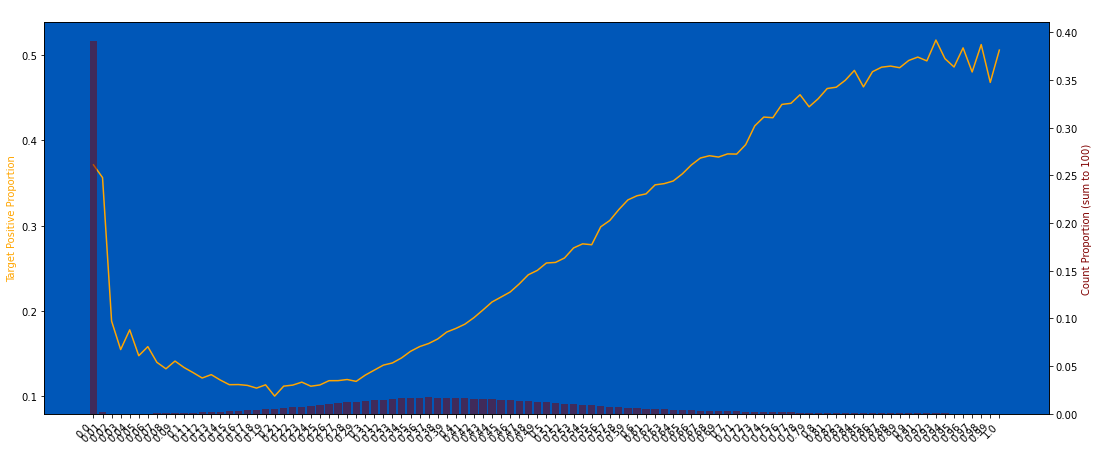

In [154]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

In [155]:
train, test = fill_nans(train, test, col="S_27", method="point", tuple_of_values=(0, 0.01), add_new_col=False)

3024198 null count, 0.547 null proportion
0.2778 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


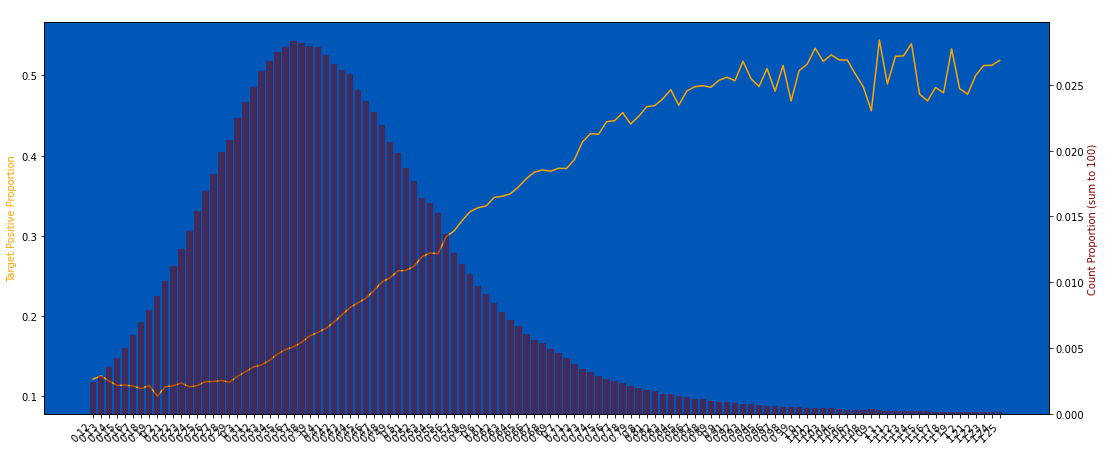

In [156]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


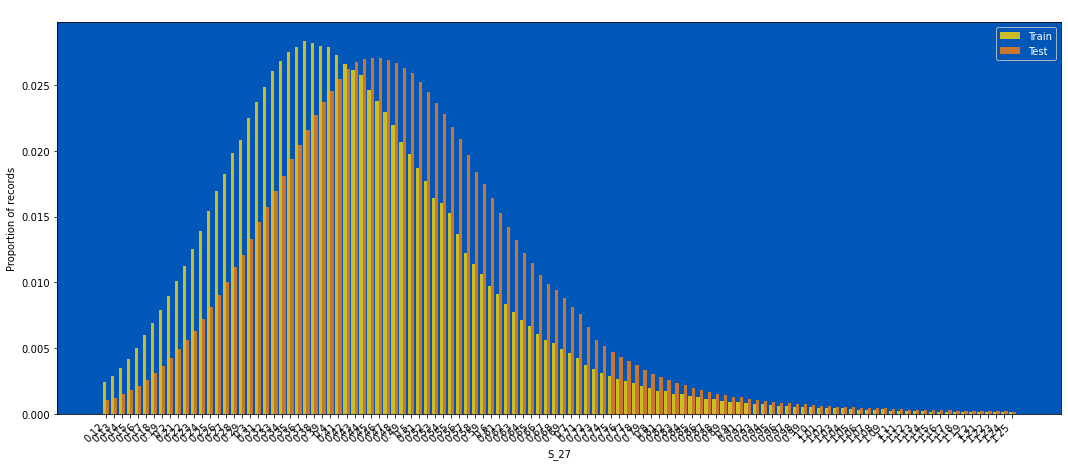

In [157]:
plot_train_test_distribution(train, test, "S_27", nunique_thr=1500)

**Train Test Skew: Heavy**

### Column checking

In [158]:
from tqdm import tqdm

In [159]:
all_columns = get_cols(train, ["P_", "S_"])

In [160]:
for d in tqdm(all_columns):
    train[d] = train[d].fillna(-127)
    test[d] = test[d].fillna(-127)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:19<00:00,  1.42it/s]


In [161]:
d_col_nunique = train[all_columns].nunique()

In [162]:
less_unique_d_cols = d_col_nunique[d_col_nunique < 64].index.tolist()

In [163]:
for d in less_unique_d_cols:
    print(d, ":", train[d].dtype, "\n", sorted(train[d].unique().tolist()), "\n")

S_6 : int32 
 [0, 1] 

S_8 : float64 
 [-127.0, 0.1, 0.11, 0.12, 0.16, 0.17, 0.24, 0.25, 0.31, 0.32, 0.33, 0.35, 0.36, 0.4, 0.41, 0.45, 0.46, 0.47, 0.48, 0.49, 0.59, 0.6, 0.61, 0.66, 0.67, 0.7, 0.71, 0.74, 0.75, 0.76, 0.85, 0.86, 0.91, 0.92, 0.93, 0.94, 1.0, 1.01, 1.02, 1.1, 1.11, 1.14, 1.15, 1.16, 1.22, 1.23] 

S_13 : float64 
 [-127.0, 7.0, 10.0, 13.0, 14.0, 16.0, 17.0, 21.0, 25.0] 

S_15 : float64 
 [-127.0, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3] 

P_4 : float64 
 [-127.0, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22,

In [164]:
cols = ["S_13", "S_18", "S_20"]

In [165]:
for col in tqdm(cols):
    train[col] = integerize(train[col])
    test[col] = integerize(test[col])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.63it/s]


In [166]:
%%time
train = train.drop(columns="temp", errors="ignore")
test = test.drop(columns="temp", errors="ignore")

CPU times: user 583 ms, sys: 841 ms, total: 1.42 s
Wall time: 1.52 s


In [173]:
%%time
train, test = drop_temp_columns(train, test)

Drop 0 columns
CPU times: user 317 ms, sys: 266 ms, total: 583 ms
Wall time: 579 ms


In [178]:
train.shape, test.shape

((5531451, 26), (11363762, 25))

In [179]:
train.columns

Index(['customer_ID', 'S_2', 'P_2', 'S_3', 'P_3', 'S_5', 'S_6', 'S_7', 'S_8',
       'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'P_4', 'S_16', 'S_17', 'S_18',
       'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'target'],
      dtype='object')

In [175]:
%%time
train.to_parquet(f"{INTERIM_TRAIN_PARQUET_PATH}/spend_payment_only.parquet")
test.to_parquet(f"{INTERIM_TEST_PARQUET_PATH}/spend_payment_only.parquet")

CPU times: user 7.33 s, sys: 586 ms, total: 7.91 s
Wall time: 7.11 s


In [176]:
END = time.time()

In [177]:
print(f"{END - START:.2f} seconds elapsed")

237.08 seconds elapsed


In [172]:
# missing_df = plot_missing_proportion_barchart(train)